In [1]:
import numpy as np
import pickle
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AutoTokenizer, AutoModel, AutoConfig
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from scikitplot.decomposition import plot_pca_2d_projection, plot_pca_component_variance
import torch.nn.functional as F

from functools import partial
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature
from modular_transformers.models import components

# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
path = "/om2/user/jackking/modular_transformers/scripts/attention_interpretability"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_grad_enabled(False)



/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Getting Sentences

In [2]:
def get_sentences_by_min_curve(datatype, model_name, num_sent_selected):

    curvatures = pickle.load(open(f"{path}/data/{datatype}/{model_name}_curvatures.pkl", "rb"))
    sentences = pickle.load(open(f"{path}/data/{datatype}/sentences.pkl", "rb"))

    #pick curved x sentences with highest curvature and curved x sentences with lowest curvature
    curvature = np.min(curvatures["curve"], axis=0)

    curved_sentence_indices = np.argsort(curvature)[-num_sent_selected:]
    straight_sentence_indices = np.argsort(curvature)[:num_sent_selected]

    curved_sentences = torch.tensor([sentences[i] for i in curved_sentence_indices])
    curved_curvatures = [curvatures["curve"][:, i] for i in curved_sentence_indices]
    straight_sentences = torch.tensor([sentences[i] for i in straight_sentence_indices])
    straight_curvatures = [curvatures["curve"][:, i] for i in straight_sentence_indices]
    sentences = torch.tensor(sentences)

    return curved_sentences, curved_curvatures, straight_sentences, straight_curvatures

def get_sentences_by_change_curve(datatype, model_name, num_sent_selected):
    
    curvatures = pickle.load(open(f"{path}/data/{datatype}/{model_name}_curvatures.pkl", "rb"))
    sentences = pickle.load(open(f"{path}/data/{datatype}/sentences.pkl", "rb"))

    changes = curvatures["curve_change"]
    max_changes = np.min(changes, axis=0)

    high_change_sentence_indices = np.argsort(max_changes)[:num_sent_selected]
    low_change_sentence_indices = np.argsort(max_changes)[-num_sent_selected:]

    straight_sentences = torch.tensor([sentences[i] for i in high_change_sentence_indices])
    straight_curvatures = [curvatures["curve"][:, i] for i in high_change_sentence_indices]
    curved_sentences = torch.tensor([sentences[i] for i in low_change_sentence_indices])
    curved_curvatures = [curvatures["curve"][:, i] for i in low_change_sentence_indices]
    sentences = torch.tensor(sentences)

    return curved_sentences, curved_curvatures, straight_sentences, straight_curvatures

def get_random_sentences(datatype, model_name, num_sent_selected):

    curvatures = pickle.load(open(f"{path}/data/{datatype}/{model_name}_curvatures.pkl", "rb"))
    sentences = pickle.load(open(f"{path}/data/{datatype}/sentences.pkl", "rb"))

    random_sentence_indices = np.random.choice(len(sentences), num_sent_selected, replace=False)
    random_sentences = torch.tensor([sentences[i] for i in random_sentence_indices])
    random_curvatures = [curvatures["curve"][:, i] for i in random_sentence_indices]

    return random_sentences, random_curvatures

### Slow and Fast Sentences

In [3]:
# sentence_length = 10
# datasource = "fineweb"
# datatype = f"{datasource}/{sentence_length}_word"
# full_path = f"{path}/data/{datatype}"

# all_sentences = pickle.load(open(f"{full_path}/all_sentences.pkl", "rb"))
# slow_sentences = pickle.load(open(f"{full_path}/slow_sentences.pkl", "rb"))
# fast_sentences = pickle.load(open(f"{full_path}/fast_sentences.pkl", "rb"))

# Record Attention Patterns

In [88]:
pre_W_activation = []

def record_pre_W_activation(input, hook):
    pre_W_activation.append(input)

def replace_W_with_identity(num_heads, attn_head_size, bias_type=True):
    def hook(input, hook):
        pre_Wk = pre_W_activation.pop()
        #refactor into n_head k vectors (code taken from Huggingface)
        new_shape = pre_Wk.size()[:-1] + (num_heads, attn_head_size)
        pre_Wk = pre_Wk.view(new_shape)
        if bias_type == "add_ones":
            pre_Wk = pre_Wk + torch.ones_like(pre_Wk)
 
        assert pre_Wk.shape == input.shape

        return pre_Wk
    return hook

def bias_type_func(input, hook):
    return input + torch.ones_like(input)

def zero_ablate():
    def hook(input, hook):
        zeroed = torch.zeros_like(input)
        return zeroed
    return hook

def noise_ablate():
    def hook(input, hook):
        noise = torch.randn_like(input)
        input_norm = torch.norm(input, dim=-1, keepdim=True)
        noise = noise * input_norm / torch.norm(noise, dim=-1, keepdim=True)
        input = input + noise
        return input
    return hook

def zero_ablate_pattern(tokens):
    def hook(input, hook):
        zeroed = torch.zeros_like(input)
        input[:, :, tokens] = zeroed[:, :, tokens]
        return input
    return hook

def noise_ablate_pattern(tokens):
    def hook(input, hook):
        noise = torch.randn_like(input)
        input_norm = torch.norm(input, dim=-1, keepdim=True)
        noise = noise * input_norm / torch.norm(noise, dim=-1, keepdim=True)
        input[:, :, tokens] = input[:, :, tokens] + noise[:, :, tokens] 
        return input
    return hook

def attn_pattern_patching_hook(target_activations, heads, tokens):
    def hook(input, hook):
        #[batch, num_heads, ctx, ctx]
        for head in heads:
            for token in tokens:
                input[:, head, token, :] = target_activations[head, token, :].unsqueeze(0).to(device)
        return input
    return hook

def attn_vector_patching_hook(target_activations, heads, tokens):
    def hook(input, hook):
        #[batch, ctx, num_heads, head_dim]
        for head in heads:
            for token in tokens:
                input[:, token, head, :] = target_activations[token, head, :].unsqueeze(0).to(device)
        return input
    return hook

def patching_hook(target_activations):
    def hook(input, hook):
        return target_activations.to(device)
    return hook

def get_hooks_for_replacing_attention_weights_with_identity(layer, vector_name, model_config, bias_type=None, bias=None):
    fwd_hooks = []
    record_hook = (f"blocks.{layer}.ln1.hook_normalized", record_pre_W_activation)
    fwd_hooks.append(record_hook)
    replace_hook = (f"blocks.{layer}.attn.hook_{vector_name}", replace_W_with_identity(model_config.n_head, model_config.n_embd // model_config.n_head, bias_type))
    fwd_hooks.append(replace_hook)

    if bias_type == "add_ones":
        vectors = ["q", "k", "v"]
        vectors.remove(vector_name)
        for hook_name in vectors:
            hook = (f"blocks.{layer}.attn.hook_{hook_name}", bias_type_func)
            fwd_hooks.append(hook)
    return fwd_hooks


In [93]:
def original_ablation_mechanism(sentences, layer):
    model = GPT2LMHeadModel.from_pretrained("gpt2-xl")
    model.to(device)
    # # define an ablated model
    config = model.config
    # Ablate MLP layers in the first transformer layer
    # config.architectures = ["GPT2LMHeadModel-MLP_ablated"]
    ablated_model = GPT2LMHeadModel.from_pretrained("gpt2-xl")
    # tokenized_text = [tokenizer.tokenize(x) for x in sentences]
    # # get ids
    # indexed_tokens = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]

    layers_to_ablate=[layer]
    ablated_curvatures=[]
    for layer_to_modify in layers_to_ablate:
        ablated_state_dict=model.state_dict()
        nonablated_state_dict=ablated_model.state_dict()
        for name, param_src in ablated_state_dict.items():
            if f"h.{layer_to_modify}.attn.c_attn" in name: #and 'weight' in name:
                # print the name of the layer
                print(f'{name} is ablated')
                # Modify parameters for the specified layer
                param_dst = ablated_model.state_dict()[name]
                param_dst.copy_(param_src.data)
                # create an random matrix with shape of param_dst
                #random_matrix = torch.randn_like(param_dst)
                if 'weight' in name:
                    dim_2=config.n_embd/config.n_head
                    eye_matrix=torch.eye(param_dst.shape[0],int(config.n_head*dim_2),device=param_dst.device)
                    # repeat eye_matrix 3 times
                    # replace the beging part of param_dst with eye_matrix
                    # take the middle part of param_dst and 
                    #  it with eye_matrix
                    new_weight = torch.concat([ param_dst[:,0: int(config.n_head*dim_2)],eye_matrix,param_dst[:,2*int(config.n_head*dim_2):]], dim=1)
                    #new_weight=torch.concat([eye_matrix, param_dst[:,int(config.n_head*dim_2):]],dim=1)
                    # make sure new_weight has the same shape as param_dst
                    assert new_weight.shape==param_dst.shape

                    # repalce the param_dst with random matrix
                    param_dst.copy_(new_weight)
                    # save the ablated state dict
                    ablated_state_dict[name] = param_dst

                else:
                    #create an identity matrix with shape of param_dst
                    new_weight=torch.ones_like(param_dst,device=param_dst.device)
                # repalce the param_dst with random matrix
                param_dst.copy_(new_weight)
                # save the ablated state dict
                ablated_state_dict[name] = param_dst
            else:
                ablated_state_dict[name] = param_src.data
            # add nonablated state dict to the ablated state dict
            nonablated_state_dict[name] = param_src.data
        # print that you're doing ablation on the layer
        print(f'ablation on layer {layer_to_modify}')
        ablated_model.load_state_dict(ablated_state_dict, strict=False)
        ablated_model.cuda()
        all_layers_unt = compute_model_activations(ablated_model, sentences, device)
        curvature_dict_ablated = compute_model_curvature(all_layers_unt)
        return curvature_dict_ablated

def get_curvature_for_normal_model(sentences, model_name):
    model = GPT2LMHeadModel.from_pretrained(model_name)
    model.to(device)
    model.eval()
    activations = compute_model_activations(model, sentences, device)
    curvatures = compute_model_curvature(activations)
    return curvatures

def get_patterns_from_cache(cache, n_layer):
    shape = cache["pattern", 0, "attn"].shape
    head_patterns = torch.zeros((n_layer, shape[0], shape[1], shape[2], shape[3]))
    for layer in range(n_layer):
        head_patterns[layer] = cache["pattern", layer, "attn"]
    return head_patterns

def get_cache(sentences, model_name, model_config, 
              ablation_location = None,
              weight_type = None,
              bias_type=None, 
              layers=None, 
              return_patterns=False,
              heads=None,
              tokens=None,
              return_logits=False):
    
    model = HookedTransformer.from_pretrained(model_name, device=device, center_writing_weights=False, fold_ln = False)
    fwd_hooks = None

    n_head = model_config.n_head
    n_embd = model_config.n_embd
    head_dim = n_embd // n_head

    if heads is None: heads = list(range(n_head))
    if tokens is None: tokens = list(range(len(sentences[0])))
    if type(layers) == int: layers = [layers]
    if layers is None: layers = []

    fwd_hooks = []

    for layer in layers:

        if ablation_location == "pattern":
            if weight_type == "zero":
                fwd_hooks.append((f"blocks.{layer}.attn.hook_pattern", zero_ablate_pattern(tokens)))
            else:
                fwd_hooks.append((f"blocks.{layer}.attn.hook_pattern", noise_ablate_pattern(tokens)))

        elif ablation_location is not None:
            ablation_location = ablation_location.upper()

            for name, param in model.named_parameters():
                
                if not weight_type == "same":
                    if name == f"blocks.{layer}.attn.W_{ablation_location}":
                        if weight_type == "identity": 
                            new_weight = torch.zeros((n_head, n_embd, head_dim))
                            for i in range(n_head):
                                for j in range(head_dim):
                                    new_weight[i, i * head_dim + j, j] = 1
                        elif weight_type == "zero": new_weight = torch.zeros_like(param)
                        for head_idx in heads:
                            param.data[head_idx] = new_weight[head_idx]
                
                if not bias_type == "same" and not bias_type == None:
                    if name == f"blocks.{layer}.attn.b_{ablation_location}":
                        if bias_type == "ones": new_bias = torch.ones_like(param)
                        elif bias_type == "zero": new_bias = torch.zeros_like(param)
                        elif bias_type == "random": new_bias = torch.randn_like(param)
                        for head_idx in heads:
                            param.data[head_idx] = new_bias[head_idx]

        if ablation_location is None and weight_type == "zero":
            fwd_hooks.append((f"blocks.{layer}.hook_attn_out", zero_ablate()))
        elif ablation_location is None and weight_type == "noise":
            fwd_hooks.append((f"blocks.{layer}.hook_attn_out", noise_ablate()))

    model.to(device)
    model.eval()
    
    if len(fwd_hooks) > 0:
        for name, hook in fwd_hooks:
            model.add_perma_hook(name=name, hook=hook)

    out, cache = model.run_with_cache(sentences, return_type="logits")

    del model

    if return_patterns:
        return get_patterns_from_cache(cache, model_config.n_layer).cpu().numpy()
    elif return_logits:
        return out, cache
    else:
        return cache.to("cpu")

def activation_patching(target_sentences, ablated_sentences, model_name, model_config, location, heads, layers, tokens):
    target_cache = get_cache(target_sentences, model_name, model_config)

    target_dict = {}
    for layer in layers:
        layer_location = f"blocks.{layer}.{location}"
        target_dict[layer] = target_cache[layer_location].mean(dim=0)

    model = HookedTransformer.from_pretrained(model_name, device=device, center_writing_weights=False, fold_ln = False)
    model.to(device)
    model.eval()

    for layer in layers:
        layer_location = f"blocks.{layer}.{location}"
        target_activation = target_dict[layer]

        if "pattern" in location:
            model.add_perma_hook(name=layer_location, hook=attn_pattern_patching_hook(target_activation, heads, tokens))
        elif "_z" in location or "_q" in location or "_k" in location or "_v" in location:
            model.add_perma_hook(name=layer_location, hook=attn_vector_patching_hook(target_activation, heads, tokens))
        else:
            model.add_perma_hook(name=layer_location, hook=patching_hook(target_activation, tokens))

    out, cache = model.run_with_cache(ablated_sentences)

    return cache

def get_curvature_for_model(cache, sentences, model_config):
    sentence_length = len(sentences[0])
    new_activations = torch.zeros((model_config.n_layer, len(sentences), sentence_length, model_config.n_embd))
    for layer in range(model_config.n_layer):
        new_activations[layer] = cache[f"blocks.{layer}.hook_resid_post"]
    #switch to (samples, layers, tokens, hidden_size)
    new_activations = einops.rearrange(new_activations, "l s t h -> s l t h")
    #compute curvature
    curvatures = compute_model_curvature(new_activations)

    return curvatures

# Visualize Attention Patterns

In [5]:
def display_all_attention_patterns(caches, names, layer, difference = False, averaged = False, num_to_show = 10, head_dim = None):
    # Create a figur        
    if difference: figsize = (20, num_to_show*4)
    if averaged: figsize = (20, 3)
    if difference and averaged: figsize = (20, 10)
    if not difference and not averaged: figsize = (25, num_to_show)
    fig = plt.figure(figsize=figsize)
      
    if difference:
        outer_grid = fig.add_gridspec(len(caches[0]), 1)
        names = names[0]
    else:
        outer_grid = fig.add_gridspec(len(caches), len(caches[0]))
    
    fig.suptitle(f'Attention patterns for layer {layer}', fontsize=16)

    for i in range(len(caches)):
        for j in range(len(caches[i])):

            if difference:
                i = 0
            
            # Add a subplot to the outer grid
            if difference: og = outer_grid[j, 0]
            else: og = outer_grid[i, j]
            outer_ax = fig.add_subplot(og)

            #remove axes
            # outer_ax.axis('off')
            outer_ax.set_title(names[i][j])
            outer_ax.set_xlabel('heads')
            outer_ax.set_ylabel('sentences')

            if difference:
                activation_pattern = caches[0][j] - caches[1][j]
            else:
                activation_pattern = caches[i][j]

            if averaged:
                activation_pattern = np.expand_dims(activation_pattern.mean(axis=0), axis=0)
            else:
                activation_pattern = activation_pattern[:num_to_show]
                
            pat_shape = activation_pattern.shape

            inner_grid = og.subgridspec(pat_shape[0], pat_shape[1])

            for sentence in range(pat_shape[0]):
                for head in range(pat_shape[1]):
                    # Add a subplot to the inner grid
                    inner_ax = fig.add_subplot(inner_grid[sentence, head])
                    inner_ax.axis('off')
                    if head_dim is not None:
                        inner_ax.imshow(activation_pattern[sentence][head].reshape(int(np.sqrt(head_dim)), -1))
                    else:
                        inner_ax.imshow(activation_pattern[sentence][head])
                    # inner_ax.set_title(f'Inner subplot {j+1}')

    # Adjust layout
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_all_attention_patterns_interleaved(caches, names, layer, averaged=False, num_to_show = 10, head_dim = None):

    # Create a figure  
    fig = plt.figure(figsize=(20, num_to_show * 8))
    if averaged: fig = plt.figure(figsize=(20, 10))
    outer_grid = fig.add_gridspec(len(caches), 1)
      
    if averaged:
        num_to_show = 1

    num_heads = caches[0][0].shape[1]

    for i in range(len(caches)):

        # Add a subplot to the outer grid
        outer_ax = fig.add_subplot(outer_grid[i, 0])
        outer_ax.set_xlabel('heads')
        outer_ax.set_ylabel('sentences')
        if i == 0:
            outer_ax.set_title('Unablated')
        else:
            outer_ax.set_title('Ablated')
        #set tiks
        outer_ax.set_xticks(np.arange(num_heads))

        inner_grid = outer_grid[i, 0].subgridspec(num_to_show*(len(caches[i])+1), num_heads)

        for sentence in range(num_to_show):
            for head in range(num_heads):
                for j in range(len(caches[i])):

                    activation_pattern = caches[i][j]

                    # Add a subplot to the inner grid
                    inner_ax = fig.add_subplot(inner_grid[sentence*(len(caches[i])+1) + j, head])
                    #turn off tics and numbers but keep labels
                    inner_ax.set_xticks([])
                    inner_ax.set_yticks([]) 

                    if head == 0:
                        inner_ax.set_ylabel(names[i][j], fontsize=8)

                    if head_dim is not None:
                        if averaged:
                            inner_ax.imshow(activation_pattern[:, head].mean(axis=0).reshape(int(np.sqrt(head_dim)), -1))
                        else:
                            inner_ax.imshow(activation_pattern[sentence][head].reshape(int(np.sqrt(head_dim)), -1))
                    else:
                        if averaged:
                            inner_ax.imshow(activation_pattern[:, head].mean(axis=0))
                        else:
                            inner_ax.imshow(activation_pattern[sentence][head])

                    #spacing
                    inner_ax = fig.add_subplot(inner_grid[sentence*(len(caches[i])+1) + len(caches[i]), head])
                    inner_ax.axis('off')

    # Adjust layout
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# PCA

In [6]:
def decompose_cache_with_PCA(activations):
    # [num_samples, num_heads, ctx_len, ctx_len]
    pca_dict = {}
    for head_idx in range(activations.shape[1]):
        head_activations = activations[:, head_idx]
        head_activations = head_activations.reshape(head_activations.shape[0], -1)
        pca = PCA()
        pca.fit(head_activations)
        pca_dict[head_idx] = pca
    return pca_dict

def display_PCA_variance(pca_dict):
    variances = [pca.explained_variance_ratio_ for pca in pca_dict.values()]
    variances = np.array(variances)
    plt.plot(variances.T)
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance")
    plt.show()
    
def display_PCA_components(pca_dict, num_components):
    for head_idx, pca in pca_dict.items():
        components = pca.components_[:num_components]
        plt.plot(components.T)
        plt.xlabel("Token")
        plt.ylabel("Component Value")
        plt.title(f"Head {head_idx}")
        plt.show()

def project_and_display_PCA_components_2D(pca_dict, activations, labels = None):
    for head_idx, pca in pca_dict.items():
        head_activations = activations[:, head_idx]
        head_activations = head_activations.reshape(head_activations.shape[0], -1)
        if labels is None:
            labels = np.zeros(head_activations.shape[0])
        plot_pca_2d_projection(pca, head_activations, labels, title=f"Head {head_idx}")
    
def reconstruct_pattern_activations(pca_dict, activations, num_components):
    reconstructed_activations = np.zeros_like(activations)
    for head_idx, pca in pca_dict.items():
        head_activations = activations[:, head_idx]
        original_shape = head_activations.shape
        head_activations = head_activations.reshape(head_activations.shape[0], -1)
        pca_components = pca.components_[:num_components]
        mean_activation = np.mean(head_activations, axis=0)
        head_activations = head_activations - mean_activation
        projected_head_activations = np.dot(head_activations, pca_components.T)
        reconstructed_head_activations = np.dot(projected_head_activations, pca_components) #+ mean_activation
        reconstructed_activations[:, head_idx] = reconstructed_head_activations.reshape(original_shape)
    return reconstructed_activations

def reconstruct_vector_activations(pca_dict, activations, num_components):
    # [num_samples, num_heads, head_dim]
    reconstructed_activations = np.zeros_like(activations)
    for head_idx, pca in pca_dict.items():
        head_activations = activations[:, head_idx]
        original_shape = head_activations.shape
        pca_components = pca.components_[:num_components]
        mean_activation = np.mean(head_activations, axis=0)
        head_activations = head_activations - mean_activation
        projected_head_activations = np.dot(head_activations, pca_components.T)
        reconstructed_head_activations = np.dot(projected_head_activations, pca_components) #+ mean_activation
        reconstructed_activations[:, head_idx] = reconstructed_head_activations.reshape(original_shape)
    return reconstructed_activations

In [7]:
datasource = "ud"
sentence_length = 10
datatype = f"{datasource}/{sentence_length}_word"
model_name = "gpt2-xl"
model_config = AutoConfig.from_pretrained(model_name)
num_sent_selected = 50

curved_sentences, curved_curvatures, straight_sentences, straight_curvatures = get_sentences_by_min_curve(datatype, model_name, num_sent_selected)
random_sentences_1, random_curvatures_1 = get_random_sentences(datatype, model_name, num_sent_selected)
random_sentences_2, random_curvatures_2 = get_random_sentences(datatype, model_name, num_sent_selected)
all_sentences, all_curvatures = get_random_sentences(datatype, model_name, 1000)
# all_sentences = torch.cat((curved_sentences, straight_sentences, random_sentences), dim=0)

In [ ]:
plt.plot(np.mean(curved_curvatures, axis=0) * 180 / np.pi, label="Curved")
plt.plot(np.mean(straight_curvatures, axis=0) * 180 / np.pi, label="Straighter")
plt.legend()
plt.show()

In [ ]:
#cache instructions (with get_cache)
    # to get attention patterns, set return_patterns=True
    # otherwise get_cache returns the entire TransformerLens cache
        # to get the output fo each head from cache, use get_cache()[f"blocks.{layer}.attn.hook_z"][:, token, :, :].numpy()
            # logic for handing multiple tokens at once is not set up

#visualization instructions
    #if caches are the head outputs, need to set head_dim = model_config.n_embd // model_config.n_head
    # caches can also be reconstructed heads with PCA or the PCA components themselves
    # otherwise things are pretty self explanatory

### Collect Caches

In [ ]:
layer = 14
ablation_location = "v"
weight_type = "same"
bias_type = "ones"
token = -1

ablation_location = "k"
weight_type = "identity"
bias_type = "zero"

#seems like same and ones isn't doing anything? verify that it does with curvature

caches = [[], []]

for data in [curved_sentences, straight_sentences, random_sentences_1, random_sentences_2]:
    cache = get_cache(data, model_name, model_config, return_patterns=True)[layer, :, :, :, 2:] #[f"blocks.{layer}.attn.hook_z"][:, token, :, :].numpy()
    caches[0].append(cache)
    cache = get_cache(data, model_name, model_config, layer=layer, ablation_location=ablation_location, weight_type=weight_type, return_patterns=True, bias_type=bias_type)[layer, :, :, :, 2:] #[f"blocks.{layer}.attn.hook_z"][:, token, :, :].numpy()
    caches[1].append(cache)

names = [["High Curve", "Low Curve", "Random 1", "Random 2"], ["High Curve Ablated", "Low Curve Ablated", "Random 1 Ablated", "Random 2 Ablated"]]

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


In [ ]:
display_all_attention_patterns_interleaved(caches, names, 14, averaged=False, num_to_show=2)

In [ ]:
display_all_attention_patterns(caches, names, layer, averaged=True, difference=False, num_to_show=5)

### PCA

#### Plot PCs

In [ ]:
pca_caches = [[], []]
for j in range(len(caches[0])):
    for i in range(len(caches)):
        pca_dict = decompose_cache_with_PCA(caches[i][j])
        pca_tensor = torch.zeros(caches[i][j].shape)
        for head_idx, pca in pca_dict.items():
            pca_tensor[:, head_idx, :, :] = torch.tensor(pca.components_.reshape(pca_tensor.shape[0], pca_tensor.shape[-2], pca_tensor.shape[-1]))
        pca_caches[i].append(pca_tensor)

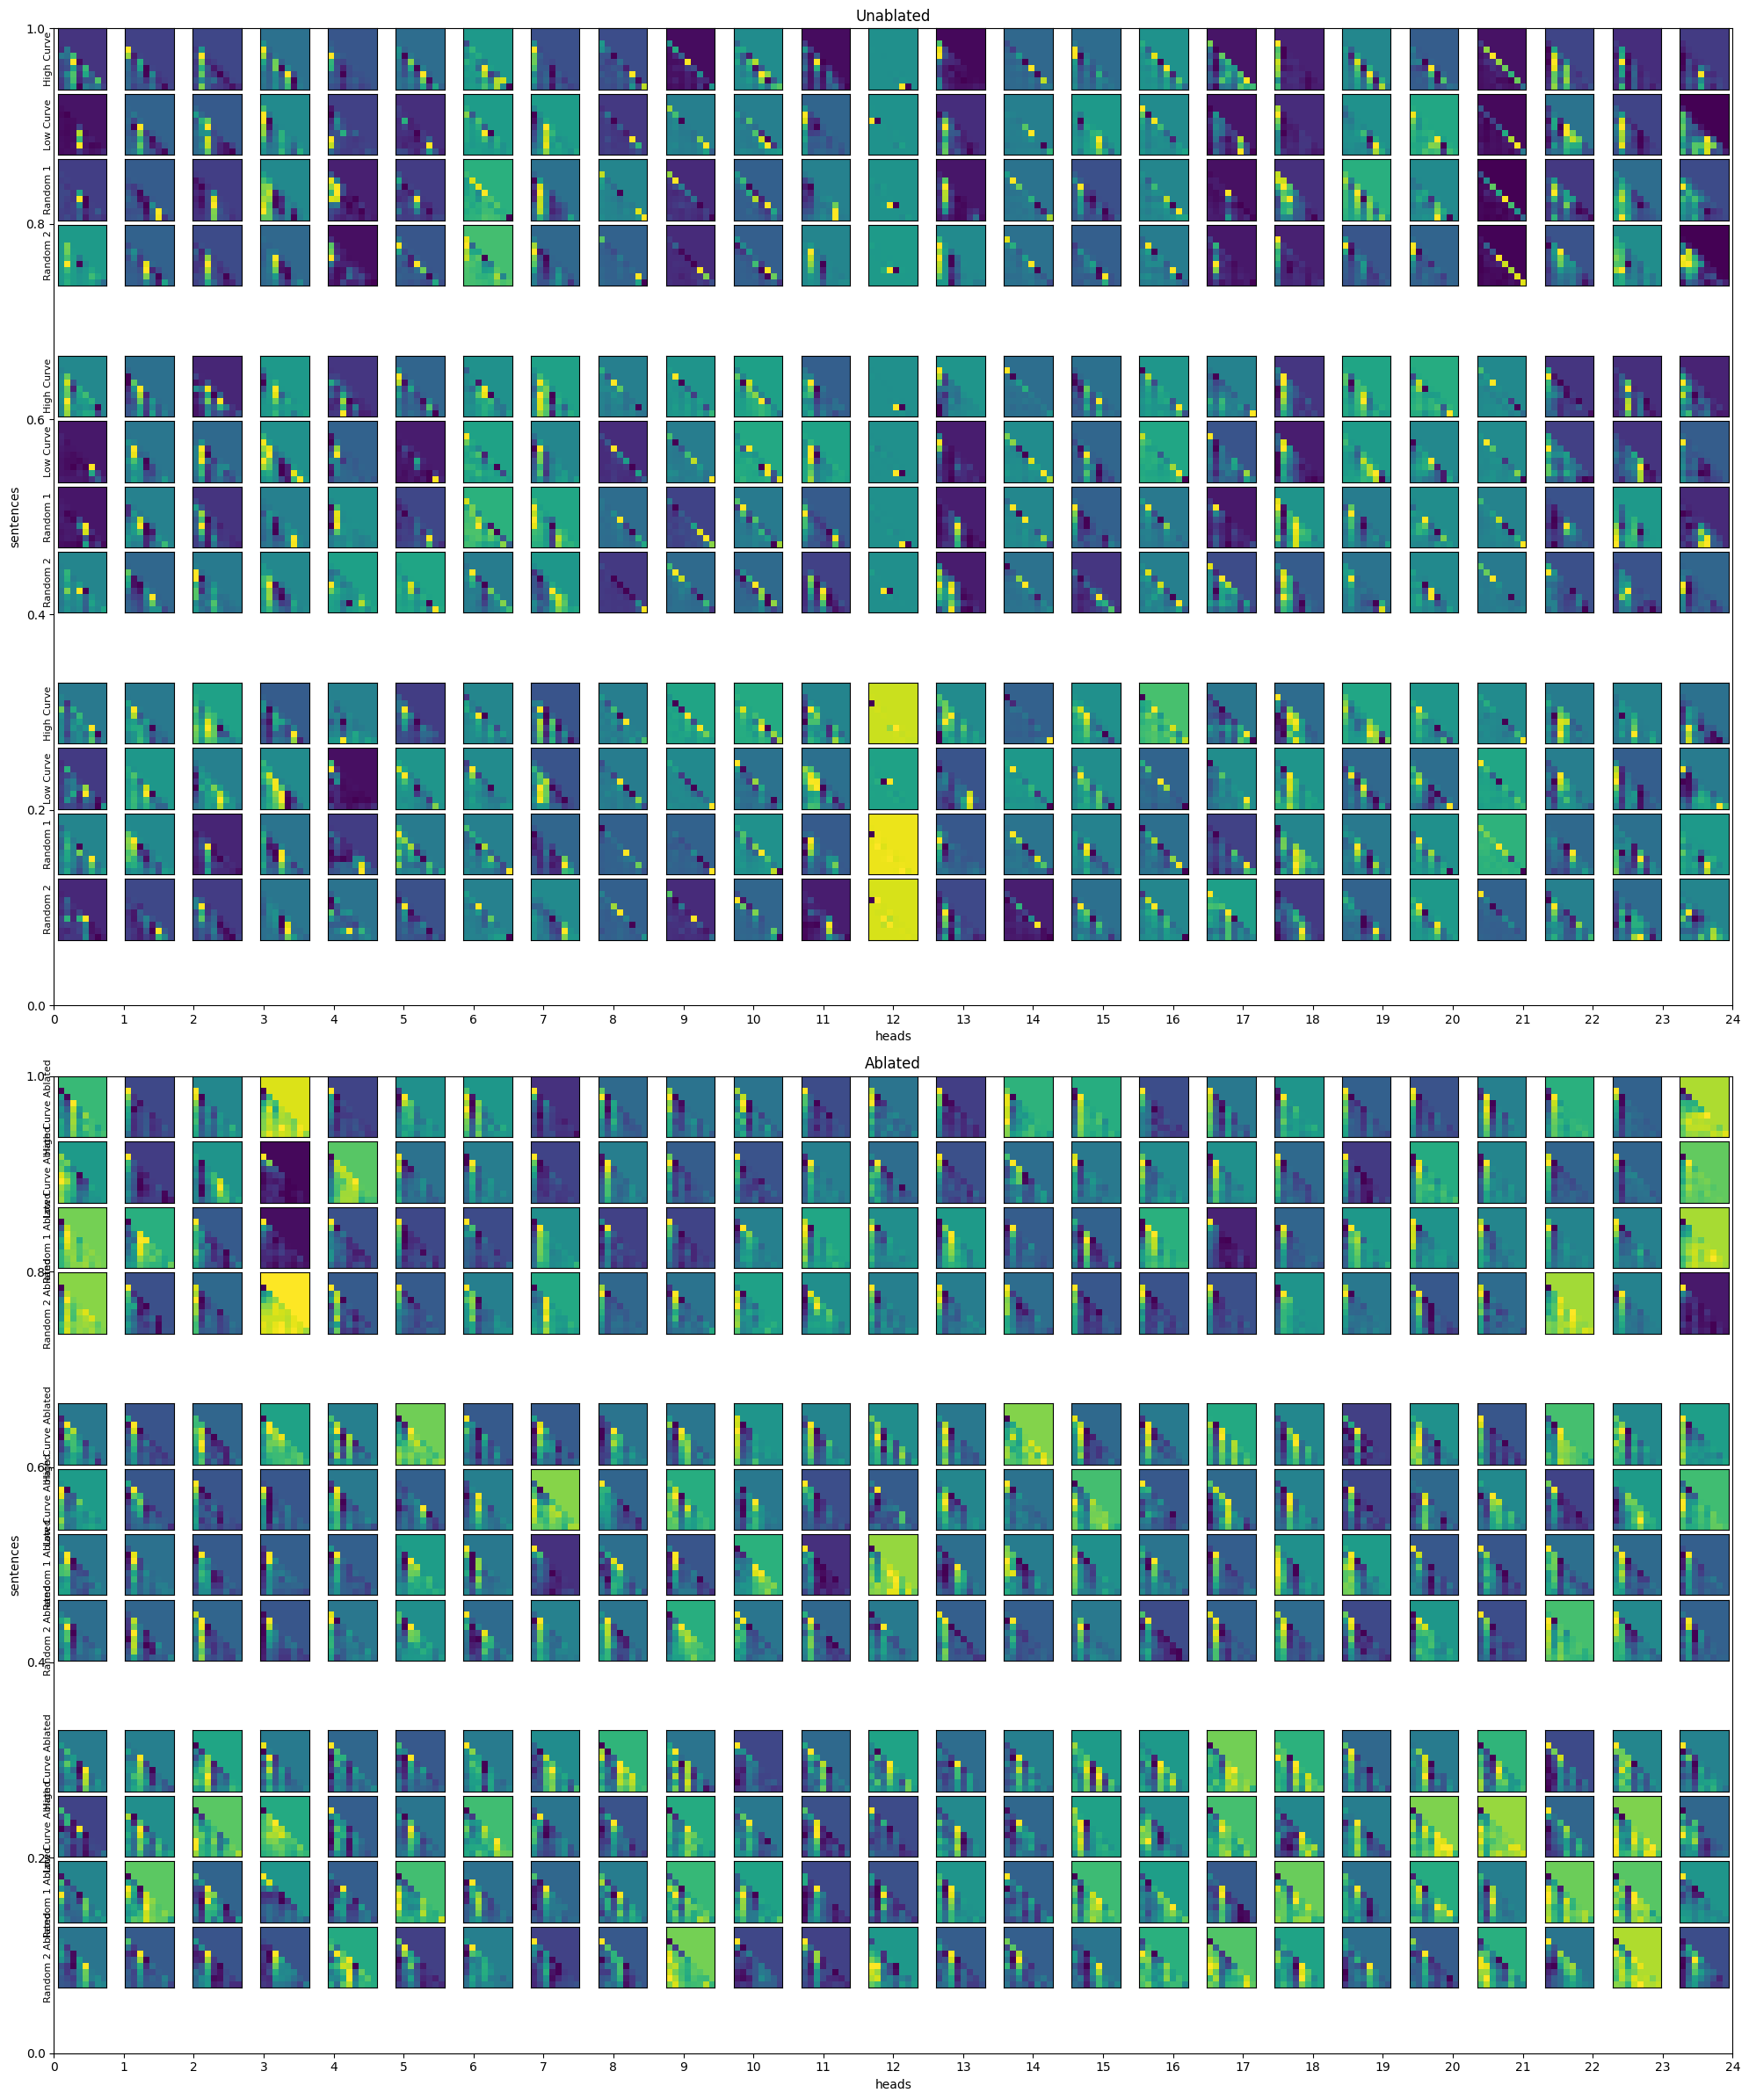

In [ ]:
#in this situation num to show refers to the number of principal components to show
display_all_attention_patterns_interleaved(pca_caches, names, 14, averaged=False, num_to_show=3)

#### Reconstruct activations

In [ ]:
layer = 14
num_components = 3
non_ablated_full_cache = np.concatenate([cache for cache in caches[0]], axis=0)
non_ablated_pca_dict = decompose_cache_with_PCA(non_ablated_full_cache)
ablated_full_cache = np.concatenate([cache for cache in caches[1]], axis=0)
ablated_pca_dict = decompose_cache_with_PCA(ablated_full_cache)

# reconstruct activations
reconstructed_caches = [[], []]
for j in range(len(caches[0])):
    reconstructed_caches[0].append(reconstruct_vector_activations(non_ablated_pca_dict, caches[0][j], num_components))
    reconstructed_caches[1].append(reconstruct_vector_activations(ablated_pca_dict, caches[1][j], num_components))

In [ ]:
pca_dict = decompose_cache_with_PCA(caches[0][0])
for head in range(model_config.n_head):
    plot_pca_component_variance(pca_dict[head])

In [ ]:
#make a numpy array holding labels for each set of sentences in caches
labels = np.zeros((4, 50))
labels[0] = 0
labels[1] = 1
labels[2] = 2
labels[3] = 2
labels = labels.flatten()

project_and_display_PCA_components_2D(non_ablated_pca_dict, non_ablated_full_cache, labels)

In [ ]:
select_caches = [[], []]

for j in range(len(caches[0]) - 1):
    select_caches[0].append(caches[0][j])
    select_caches[1].append(caches[1][j])

In [ ]:
display_all_attention_patterns(select_caches, names, 14, num_to_show=10)

## Identifying the most important heads

In [ ]:
regular_cache = get_cache(random_sentences_1, model_name, model_config)
regular_curvature = get_curvature_for_model(regular_cache, random_sentences_1, model_config)
min_regular_curve = np.min(np.mean(regular_curvature["curve"], axis=1), axis=0)

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:00, 101.17it/s]


In [ ]:
layer = 14
min_curves = []
for head in range(model_config.n_head):
    cache = get_cache(random_sentences_1, model_name, model_config, ablation_location="v", weight_type="same", bias_type="ones", layer=layer, heads=[head])
    curvature = get_curvature_for_model(cache, random_sentences_1, model_config)
    min_curve = np.max(np.mean(curvature["curve"], axis=1)[20:35], axis=0)
    min_curves.append(min_curve)
    plt.plot(np.mean(curvature["curve"], axis=1))
    plt.plot(np.mean(regular_curvature["curve"], axis=1))
    plt.show()

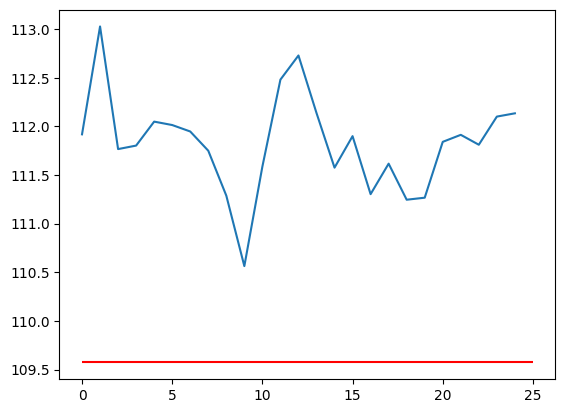

In [ ]:
#from 10x is head 1
#from 3x, ablating head 11 increases curvature the most and head 9 decreases it the most
#could try identity
plt.plot(np.array(min_curves) * 180 / np.pi)
plt.hlines(min_regular_curve * 180 / np.pi, 0, 25, color="red")

## Activation Patching

In [ ]:
#patch in the activations from the least curved sentences into the most curved sentences
layers = [14]
layers = [10, 11, 12, 13, 14, 15, 16, 17]
location = f"attn.hook_pattern"
# location = f"hook_attn_out"
# location = f"attn.hook_z"
heads = np.arange(model_config.n_head)
# heads = [11]
tokens = [-1]
target_sentences = straight_sentences #sentences to inject into patched sentences
patched_sentences = curved_sentences #sentences to inject into
patched_cache = activation_patching(target_sentences, patched_sentences, model_name, model_config, location, heads, layers, tokens)
patched_curvature = get_curvature_for_model(patched_cache, patched_sentences, model_config)
original_cache = get_cache(patched_sentences, model_name, model_config)
original_curvature = get_curvature_for_model(original_cache, patched_sentences, model_config)

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


50it [00:00, 94.78it/s]


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


50it [00:00, 97.84it/s]


In [ ]:
target_sentences = straight_sentences #sentences to inject into patched sentences
patched_sentences = curved_sentences #sentences to inject into

original_cache = get_cache(patched_sentences, model_name, model_config)
original_curvature = get_curvature_for_model(original_cache, patched_sentences, model_config)

location = f"attn.hook_pattern"
location = f"attn.hook_z"

tokens = np.arange(10)
layers = [12, 13, 14, 15, 16]
heads = np.arange(model_config.n_head)

curvatures = []
curvatures_dict = {}

for layer in layers:
    curvatures_dict[layer] = {}
    for head in heads:
        patched_cache = activation_patching(target_sentences, patched_sentences, model_name, model_config, location, [head], [layer], tokens)
        patched_curvature = get_curvature_for_model(patched_cache, patched_sentences, model_config)
        # curvatures.append(patched_curvature)
        curvatures_dict[layer][head] = patched_curvature

In [77]:
difs = []
for layer in layers:
    for head in heads:
        argmin = np.argmin(original_curvature["curve"], axis=1)
        dif = curvatures_dict[layer][head]["curve"][argmin] - original_curvature["curve"][argmin]
        dif_mean = np.mean(dif)
        difs.append((dif_mean, layer, head))

In [78]:
difs = sorted(difs, key=lambda x: x[0])
print(difs)

[(0.0, 12, 0), (0.0, 12, 1), (0.0, 12, 2), (0.0, 12, 3), (0.0, 12, 4), (0.0, 12, 5), (0.0, 12, 6), (0.0, 12, 7), (0.0, 12, 8), (0.0, 12, 9), (0.0, 12, 10), (0.0, 12, 11), (0.0, 12, 12), (0.0, 12, 13), (0.0, 12, 14), (0.0, 12, 15), (0.0, 12, 16), (0.0, 12, 17), (0.0, 12, 18), (0.0, 12, 19), (0.0, 12, 20), (0.0, 12, 21), (0.0, 12, 22), (0.0, 12, 23), (0.0, 12, 24), (0.0, 13, 0), (0.0, 13, 1), (0.0, 13, 2), (0.0, 13, 3), (0.0, 13, 4), (0.0, 13, 5), (0.0, 13, 6), (0.0, 13, 7), (0.0, 13, 8), (0.0, 13, 9), (0.0, 13, 10), (0.0, 13, 11), (0.0, 13, 12), (0.0, 13, 13), (0.0, 13, 14), (0.0, 13, 15), (0.0, 13, 16), (0.0, 13, 17), (0.0, 13, 18), (0.0, 13, 19), (0.0, 13, 20), (0.0, 13, 21), (0.0, 13, 22), (0.0, 13, 23), (0.0, 13, 24), (0.0, 14, 0), (0.0, 14, 1), (0.0, 14, 2), (0.0, 14, 3), (0.0, 14, 4), (0.0, 14, 5), (0.0, 14, 6), (0.0, 14, 7), (0.0, 14, 8), (0.0, 14, 9), (0.0, 14, 10), (0.0, 14, 11), (0.0, 14, 12), (0.0, 14, 13), (0.0, 14, 14), (0.0, 14, 15), (0.0, 14, 16), (0.0, 14, 17), (0.0, 14,

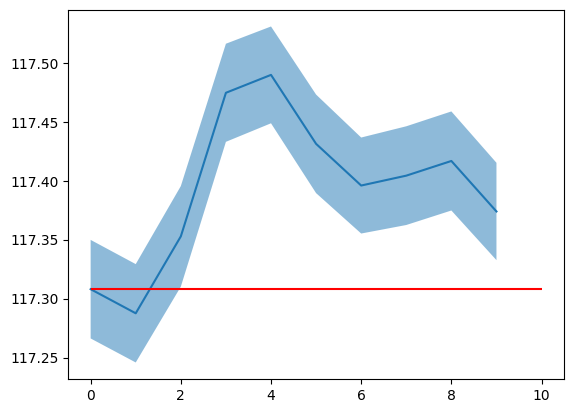

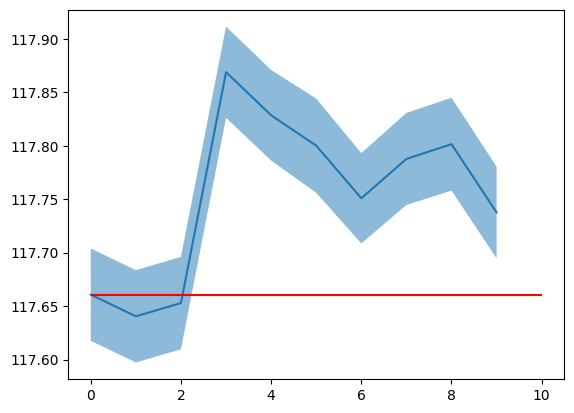

In [ ]:
#taking the minimum of the average curvature of each sentence across layers
def average_over_sentences(curvatures):

    full_curvature = []
    stds = []
    for curvature in curvatures:

        mean_curve_over_sentences = np.mean(curvature["curve"], axis=1)
        min_layer = np.argmin(mean_curve_over_sentences)
        full_curvature.append(mean_curve_over_sentences[min_layer] * 180 / np.pi)
        stds.append(np.std(curvature["curve"][min_layer]))
    
        mean_curve_over_sentences = np.mean(original_curvature["curve"], axis=1)
        full_orig_curvature = np.min(mean_curve_over_sentences) * 180 / np.pi
    
    return full_curvature, stds, full_orig_curvature

#taking the average of the min curvature of each sentence across layers
def average_over_min_curve_of_each_sentence(curvatures):
    
        full_curvature = []
        stds = []
        for curvature in curvatures:
    
            min_curve_over_layers = np.min(curvature["curve"], axis=0)
            full_curvature.append(np.mean(min_curve_over_layers) * 180 / np.pi)
            stds.append(np.std(min_curve_over_layers))
        
        min_curve_over_layers = np.min(original_curvature["curve"], axis=0)
        full_orig_curvature = np.mean(min_curve_over_layers) * 180 / np.pi
        
        return full_curvature, stds, full_orig_curvature

full_curvature, stds, full_orig_curvature = average_over_min_curve_of_each_sentence(curvatures)

plt.plot(full_curvature)
plt.fill_between(np.arange(len(full_curvature)), np.array(full_curvature) - np.array(stds), np.array(full_curvature) + np.array(stds), alpha=0.5)
plt.hlines(full_orig_curvature, 0, 10, color="red")
plt.show()

full_curvature, stds, full_orig_curvature = average_over_sentences(curvatures)

plt.plot(full_curvature)
plt.fill_between(np.arange(len(full_curvature)), np.array(full_curvature) - np.array(stds), np.array(full_curvature) + np.array(stds), alpha=0.5)
plt.hlines(full_orig_curvature, 0, 10, color="red")
plt.show()

In [ ]:
np.array(curvatues[0]["all_layer_curve_all"]).shape


(50, 48, 8)

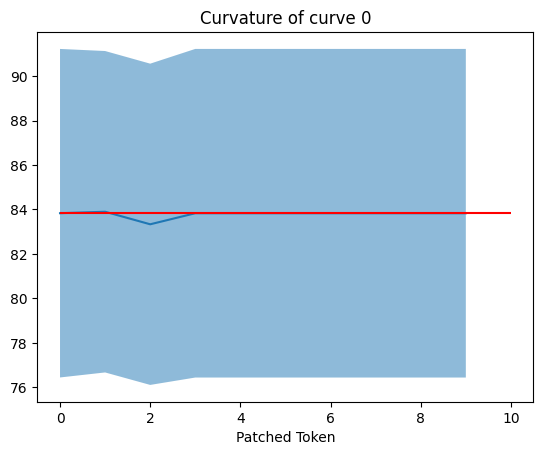

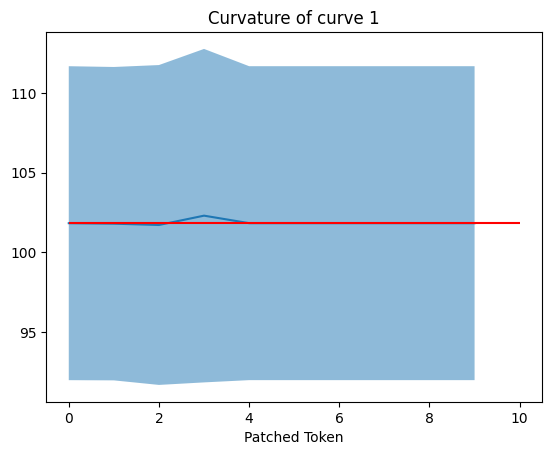

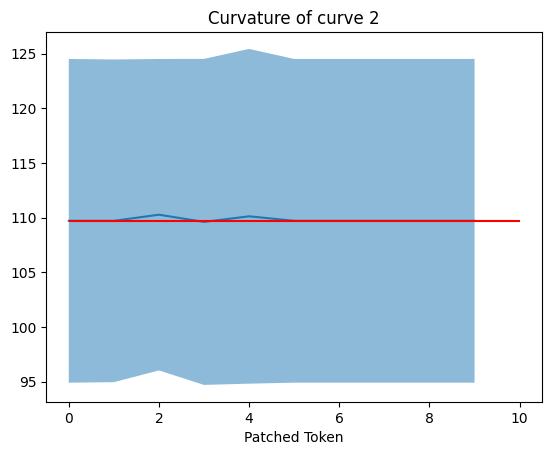

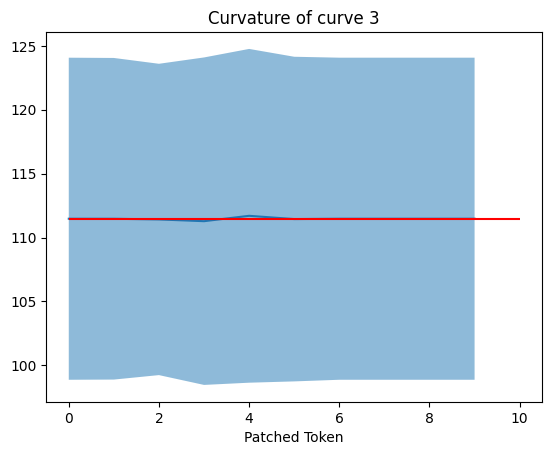

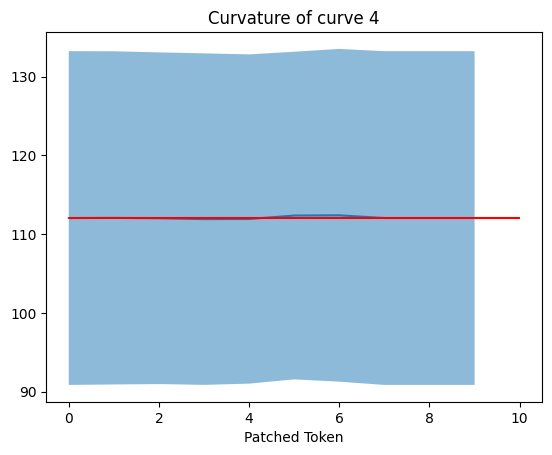

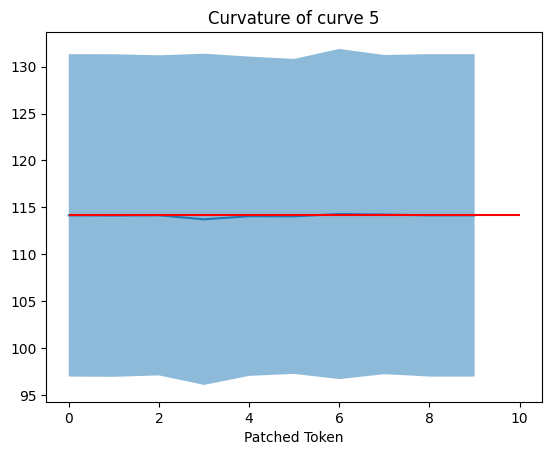

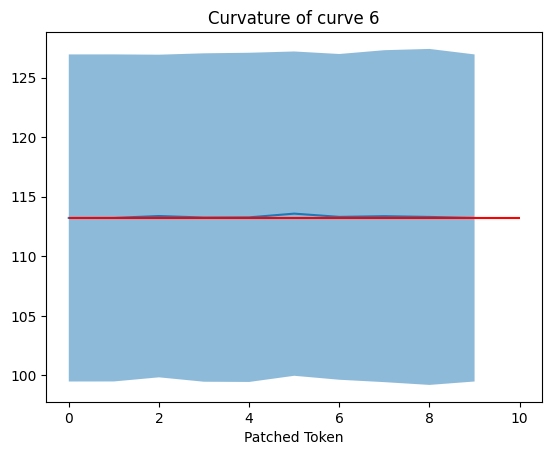

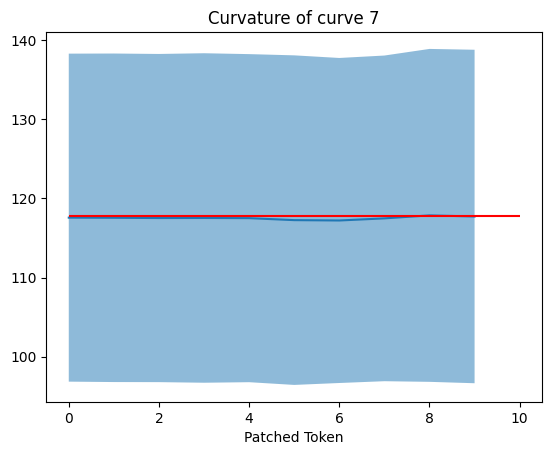

In [ ]:
#taking the average of the min curvature of each sentence across layers
for curve_idx in range(len(tokens) - 2):
    last_token_curvature = []
    stds = []
    for curvature in curvatures:
        curve = np.array(curvature["all_layer_curve_all"])[:, :, curve_idx]
        min_curve_over_sentences = np.min(curve, axis=1)
        last_token_curvature.append(np.mean(min_curve_over_sentences) * 180 / np.pi)
        stds.append(np.std(min_curve_over_sentences) * 180 / np.pi)

    plt.plot(last_token_curvature)
    plt.fill_between(np.arange(len(last_token_curvature)), np.array(last_token_curvature) - np.array(stds), np.array(last_token_curvature) + np.array(stds), alpha=0.5)
    
    curve = np.array(curvature["all_layer_curve_all"])[:, :, curve_idx]
    min_curve_over_sentences = np.min(curve, axis=1)
    plt.hlines(np.mean(min_curve_over_sentences) * 180 / np.pi, 0, 10, color="red")

    plt.title(f"Curvature of curve {curve_idx}")
    plt.xlabel("Patched Token")
    plt.show()

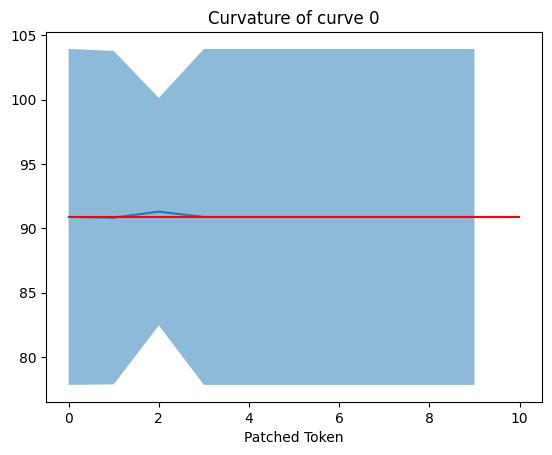

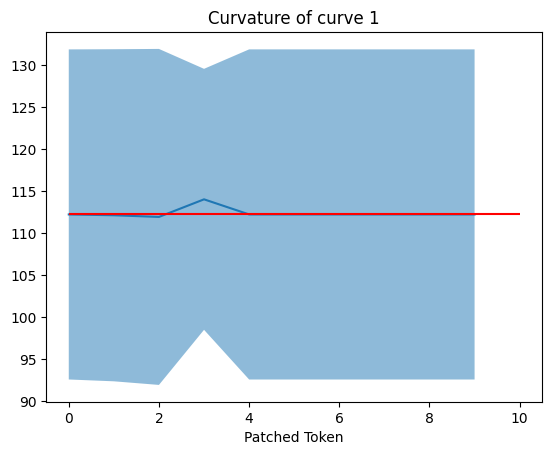

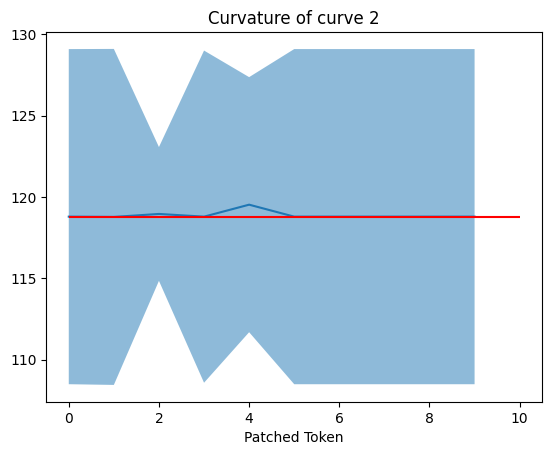

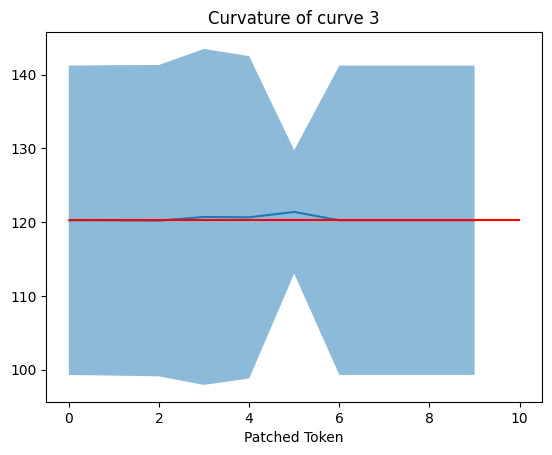

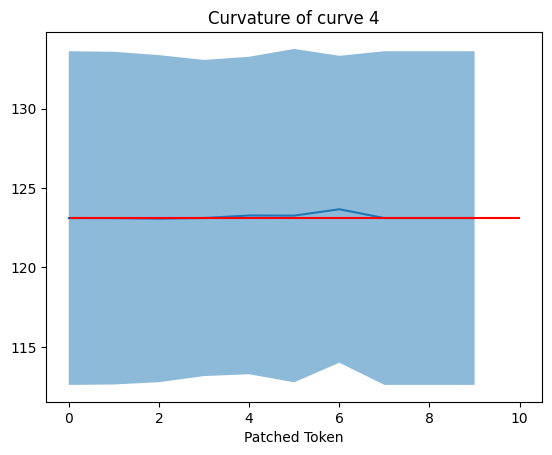

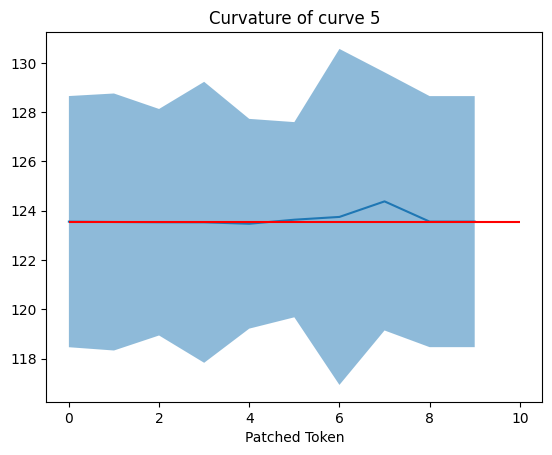

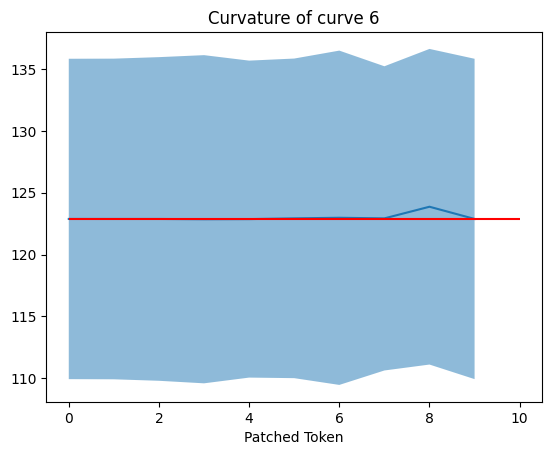

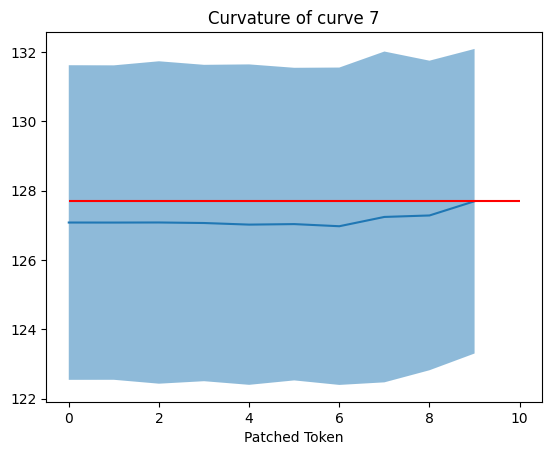

In [ ]:
#taking the minimum of the average curvature of each sentence across layers
for curve_idx in range(len(tokens) - 2):
    last_token_curvature = []
    stds = []
    for curvature in curvatues:
        curve = np.array(curvature["all_layer_curve_all"])[:, :, curve_idx]
        mean_curve_over_sentences = np.mean(curve, axis=0)
        min_layer = np.argmin(mean_curve_over_sentences)
        last_token_curvature.append(mean_curve_over_sentences[min_layer] * 180 / np.pi)
        stds.append(np.std(curve[min_layer]) * 180 / np.pi)

    plt.plot(last_token_curvature)
    plt.fill_between(np.arange(len(last_token_curvature)), np.array(last_token_curvature) - np.array(stds), np.array(last_token_curvature) + np.array(stds), alpha=0.5)
    
    curve = np.array(curvature["all_layer_curve_all"])[:, :, curve_idx]
    mean_curve_over_sentences = np.mean(curve, axis=0)
    plt.hlines(np.min(mean_curve_over_sentences) * 180 / np.pi, 0, 10, color="red")

    plt.title(f"Curvature of curve {curve_idx}")
    plt.xlabel("Patched Token")
    plt.show()


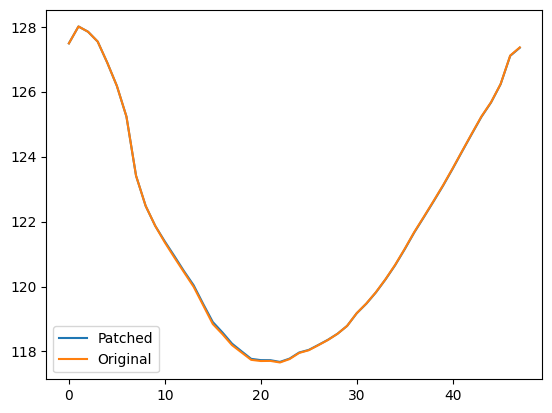

In [ ]:
#target sentences are the least curved sentences
plt.plot(patched_curvature["curve"].mean(axis=1) * 180 / np.pi, label="Patched")
plt.plot(original_curvature["curve"].mean(axis=1) * 180 / np.pi, label="Original")
plt.legend()
plt.show()

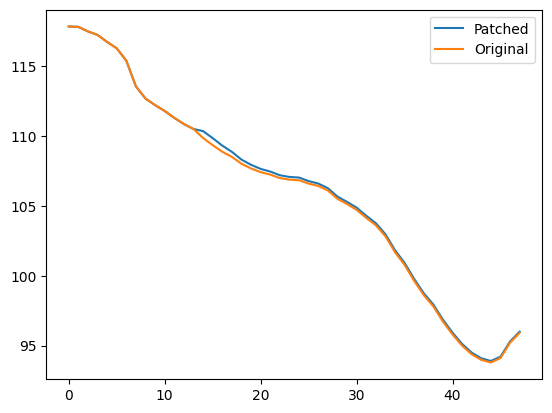

In [ ]:
#target sentences are the most curved sentences
plt.plot(patched_curvature["curve"].mean(axis=1) * 180 / np.pi, label="Patched")
plt.plot(original_curvature["curve"].mean(axis=1) * 180 / np.pi, label="Original")
plt.legend()
plt.show()

## Checking for effect of ablation on curvature

In [ ]:
regular_cache = get_cache(random_sentences_1, model_name, model_config)
regular_curvature = get_curvature_for_model(regular_cache, random_sentences_1, model_config)

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:00, 101.51it/s]


In [ ]:
layer = 14
ablation_location = "v"
weight_type = "identity"
bias_type = "same"

curvature_dict = {}
for layer in [14, 22]:
    print(f"running {layer}")
    cache = get_cache(random_sentences_1, model_name, model_config, ablation_location=ablation_location, weight_type=weight_type, bias_type=bias_type, layer=layer)
    curvature = get_curvature_for_model(cache, random_sentences_1, model_config)
    curvature_dict[layer] = curvature

running 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:00, 101.19it/s]


running 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:00, 100.55it/s]


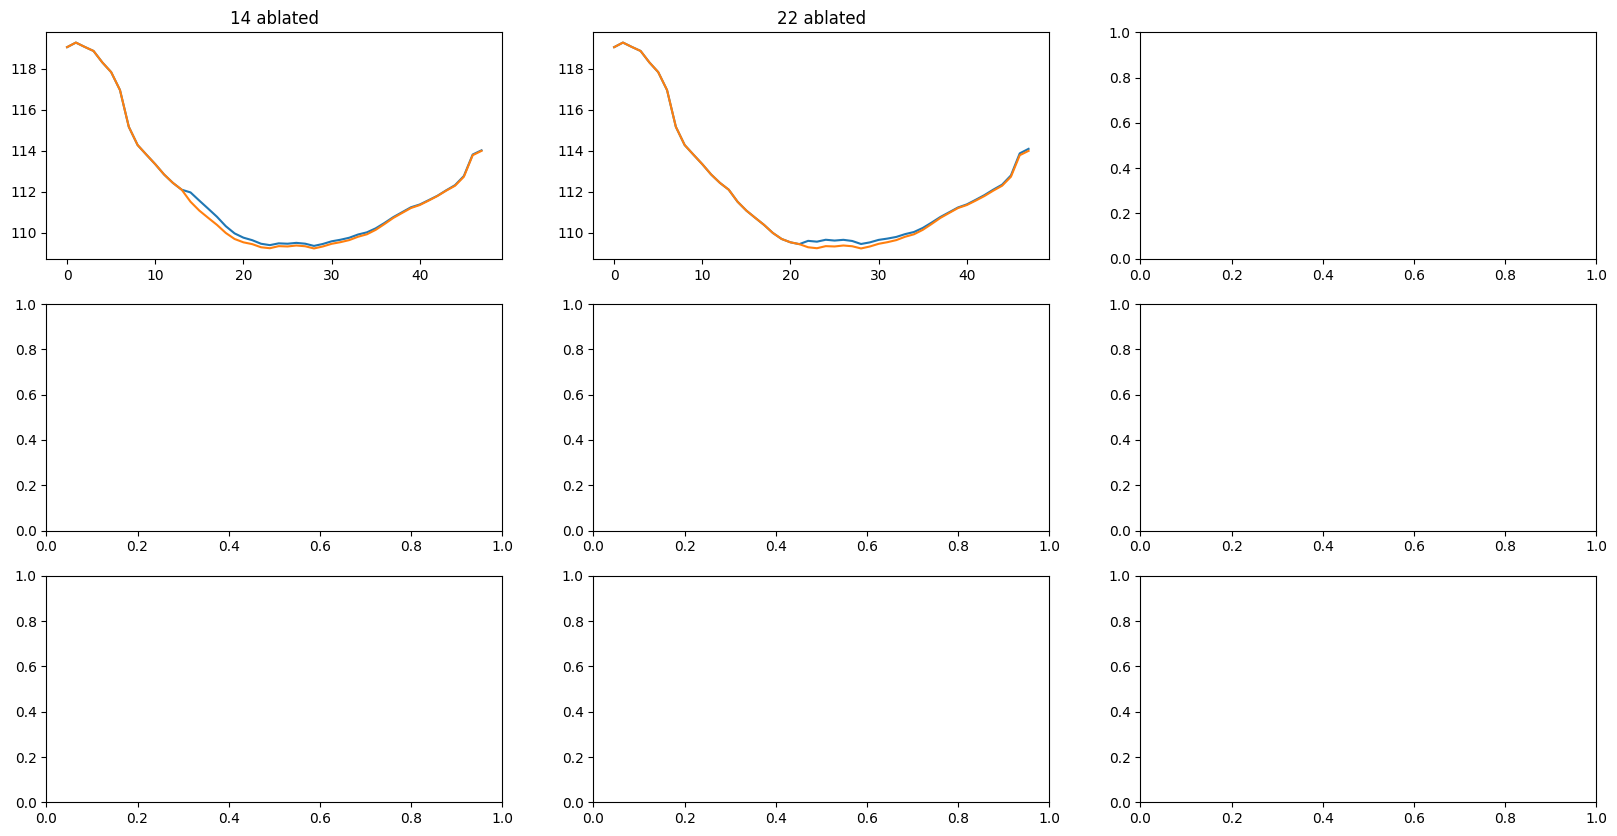

In [ ]:
#zeroed attention patterns
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for ax, (layer, curvatures) in zip(axs.flatten(), curvature_dict.items()):
    ax.plot(curvatures["curve"].mean(axis=1) * 180 / np.pi)
    ax.plot(regular_curvature["curve"].mean(axis=1) * 180 / np.pi)
    ax.set_title(f"{layer} ablated")
plt.show()

In [ ]:
all_curvature_dicts = {}
for location in ["q", "k", "v"]:
    for bias_type in ["same", "zero", "ones"]:
        for weight_type in ["same", "zero", "identity"]:
            all_curvature_dicts[(location, weight_type, bias_type)] = {}
            for layer in [14, 22, 28]:#np.arange(12, 30, 2):
                print(f"running {location}, {bias_type}, {layer}")
                cache = get_cache(random_sentences_1, model_name, model_config, ablation_location=location, weight_type=weight_type, bias_type=bias_type, layer=layer)
                curvature = get_curvature_for_model(cache, random_sentences_1, model_config)
                all_curvature_dicts[(location, weight_type, bias_type)][layer] = curvature

running q, same, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 97.25it/s]


running q, same, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 87.88it/s]


running q, same, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.54it/s]


running q, same, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 85.18it/s]


running q, same, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 97.18it/s]


running q, same, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 86.99it/s]


running q, same, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.08it/s]


running q, same, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 86.05it/s]


running q, same, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 97.10it/s]


running q, zero, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 87.60it/s]


running q, zero, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.45it/s]


running q, zero, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 86.22it/s]


running q, zero, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 97.44it/s]


running q, zero, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 86.64it/s]


running q, zero, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.84it/s]


running q, zero, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 88.60it/s]


running q, zero, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 97.52it/s]


running q, zero, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 87.59it/s]


running q, ones, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.23it/s]


running q, ones, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 89.65it/s]


running q, ones, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 97.52it/s]


running q, ones, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 89.33it/s]


running q, ones, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.80it/s]


running q, ones, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 91.87it/s]


running q, ones, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 97.95it/s]


running q, ones, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 91.36it/s]


running q, ones, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.98it/s]


running k, same, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 90.60it/s]


running k, same, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 98.21it/s]


running k, same, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 91.47it/s]


running k, same, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.87it/s]


running k, same, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.22it/s]


running k, same, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 97.18it/s]


running k, same, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.58it/s]


running k, same, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.48it/s]


running k, same, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.40it/s]


running k, zero, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 96.78it/s]


running k, zero, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.22it/s]


running k, zero, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 91.21it/s]


running k, zero, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.97it/s]


running k, zero, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.72it/s]


running k, zero, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.27it/s]


running k, zero, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 90.01it/s]


running k, zero, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.04it/s]


running k, zero, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.53it/s]


running k, ones, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.03it/s]


running k, ones, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 89.33it/s]


running k, ones, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.59it/s]


running k, ones, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.71it/s]


running k, ones, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.36it/s]


running k, ones, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 89.24it/s]


running k, ones, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.10it/s]


running k, ones, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.50it/s]


running k, ones, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.33it/s]


running v, same, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 89.15it/s]


running v, same, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.26it/s]


running v, same, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.37it/s]


running v, same, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.84it/s]


running v, same, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 89.79it/s]


running v, same, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.36it/s]


running v, same, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.84it/s]


running v, same, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.50it/s]


running v, same, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 90.55it/s]


running v, zero, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.47it/s]


running v, zero, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.48it/s]


running v, zero, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.75it/s]


running v, zero, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 89.86it/s]


running v, zero, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.69it/s]


running v, zero, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.10it/s]


running v, zero, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.19it/s]


running v, zero, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 90.52it/s]


running v, zero, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.61it/s]


running v, ones, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 97.38it/s]


running v, ones, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.05it/s]


running v, ones, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 91.00it/s]


running v, ones, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 91.69it/s]


running v, ones, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 99.00it/s]


running v, ones, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.03it/s]


running v, ones, 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 95.70it/s]


running v, ones, 22
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.05it/s]


running v, ones, 28
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 98.64it/s]


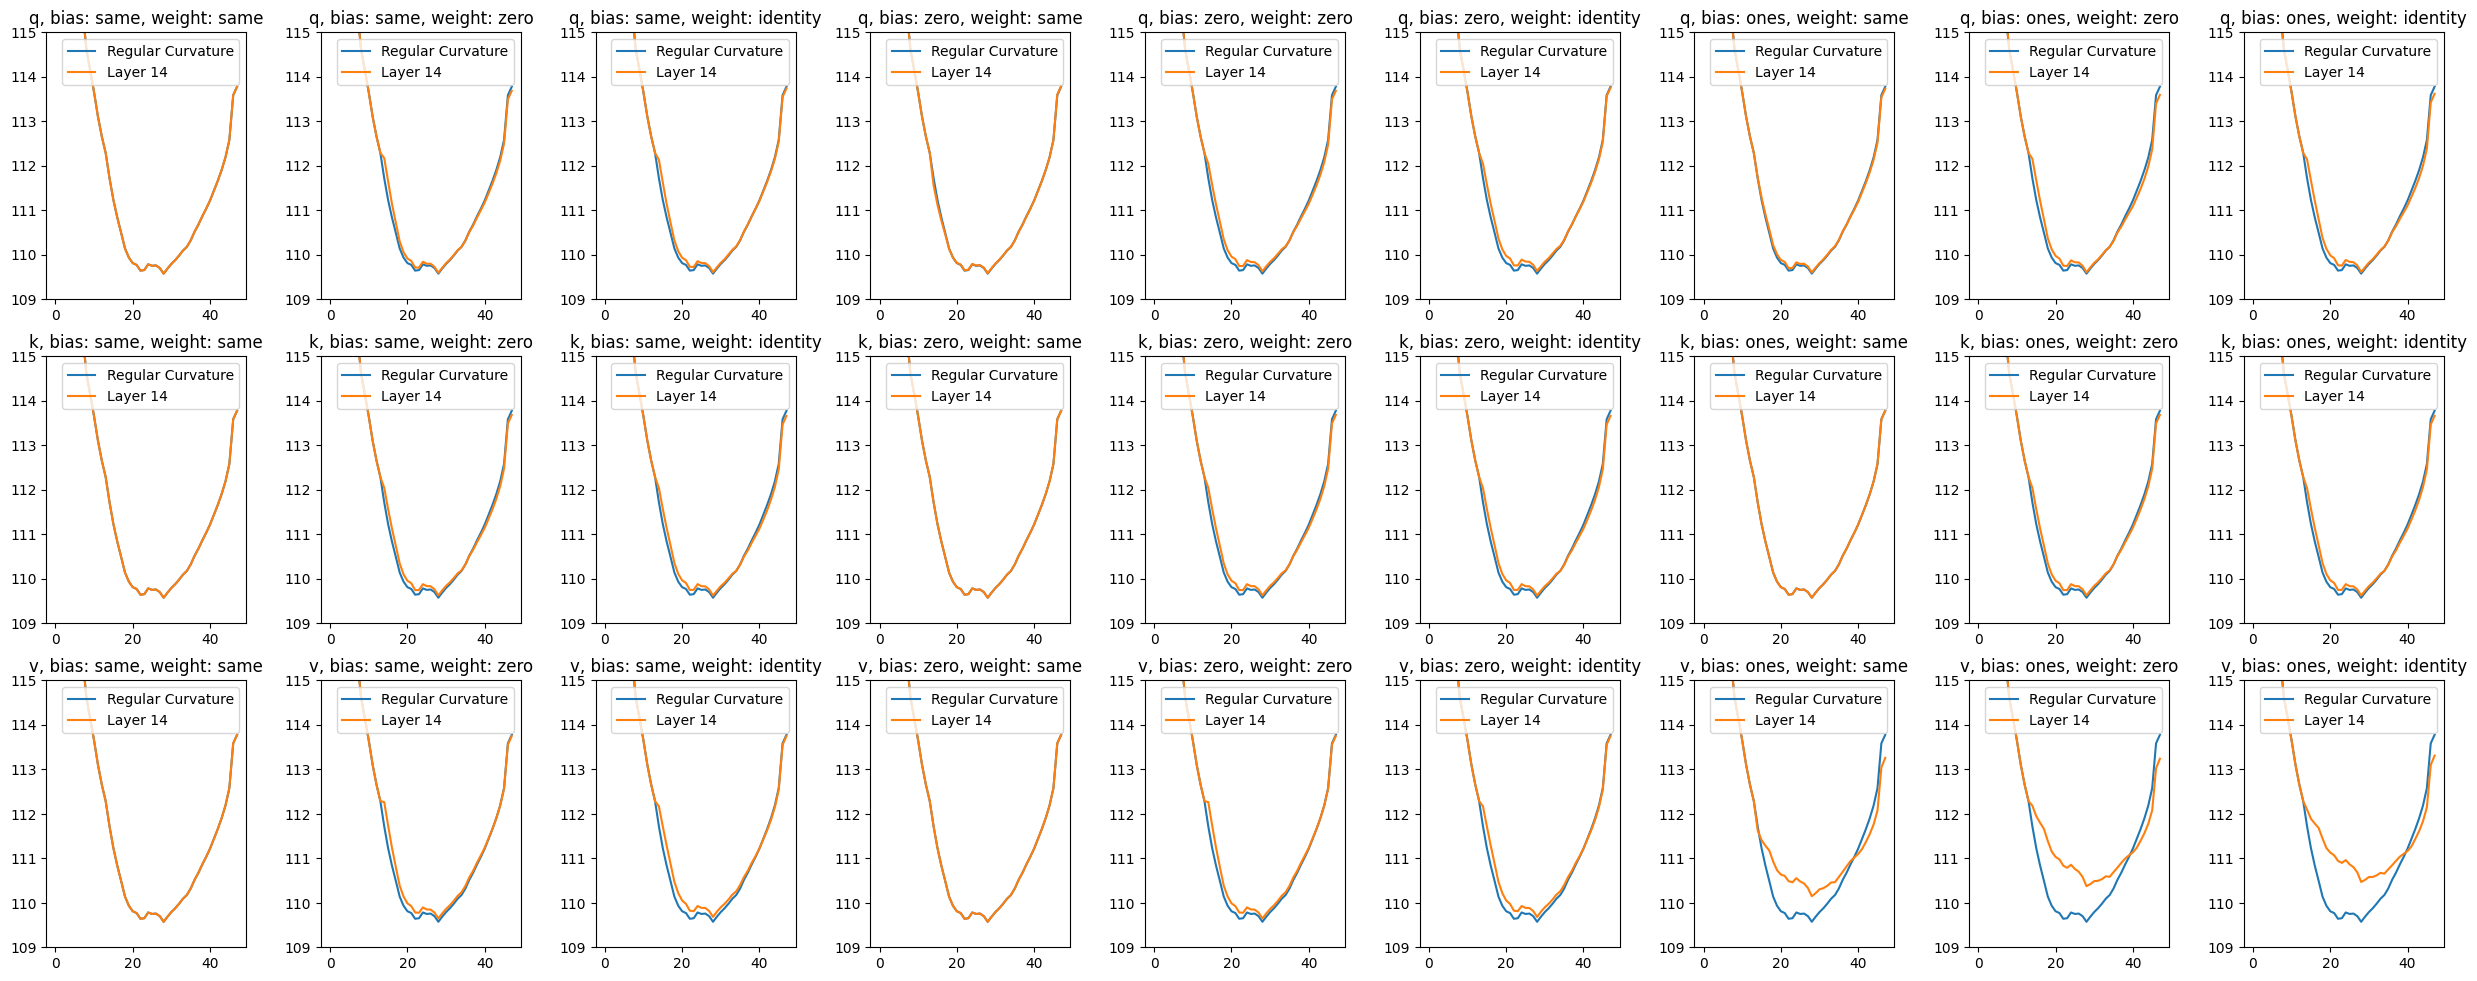

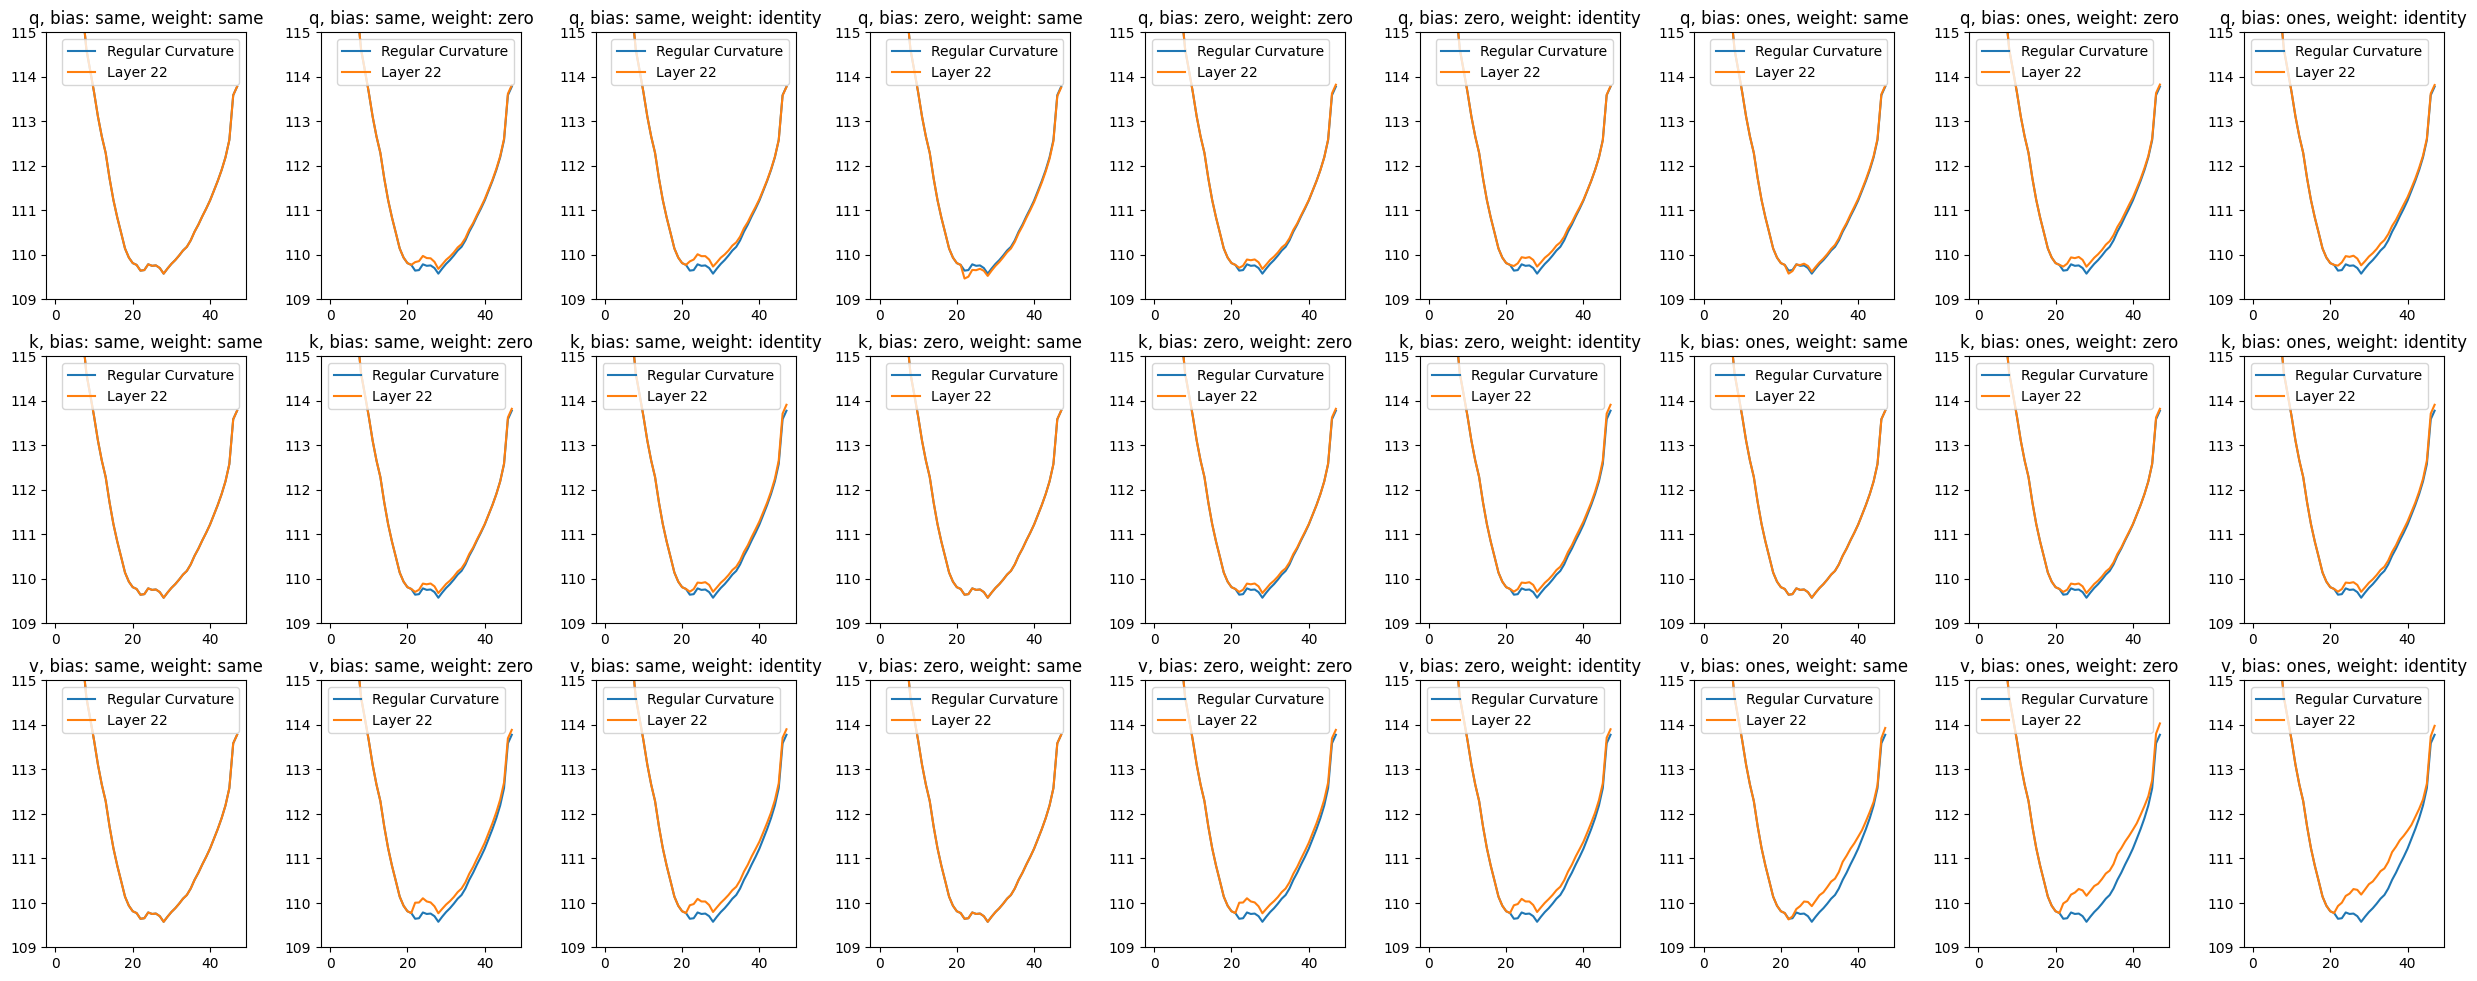

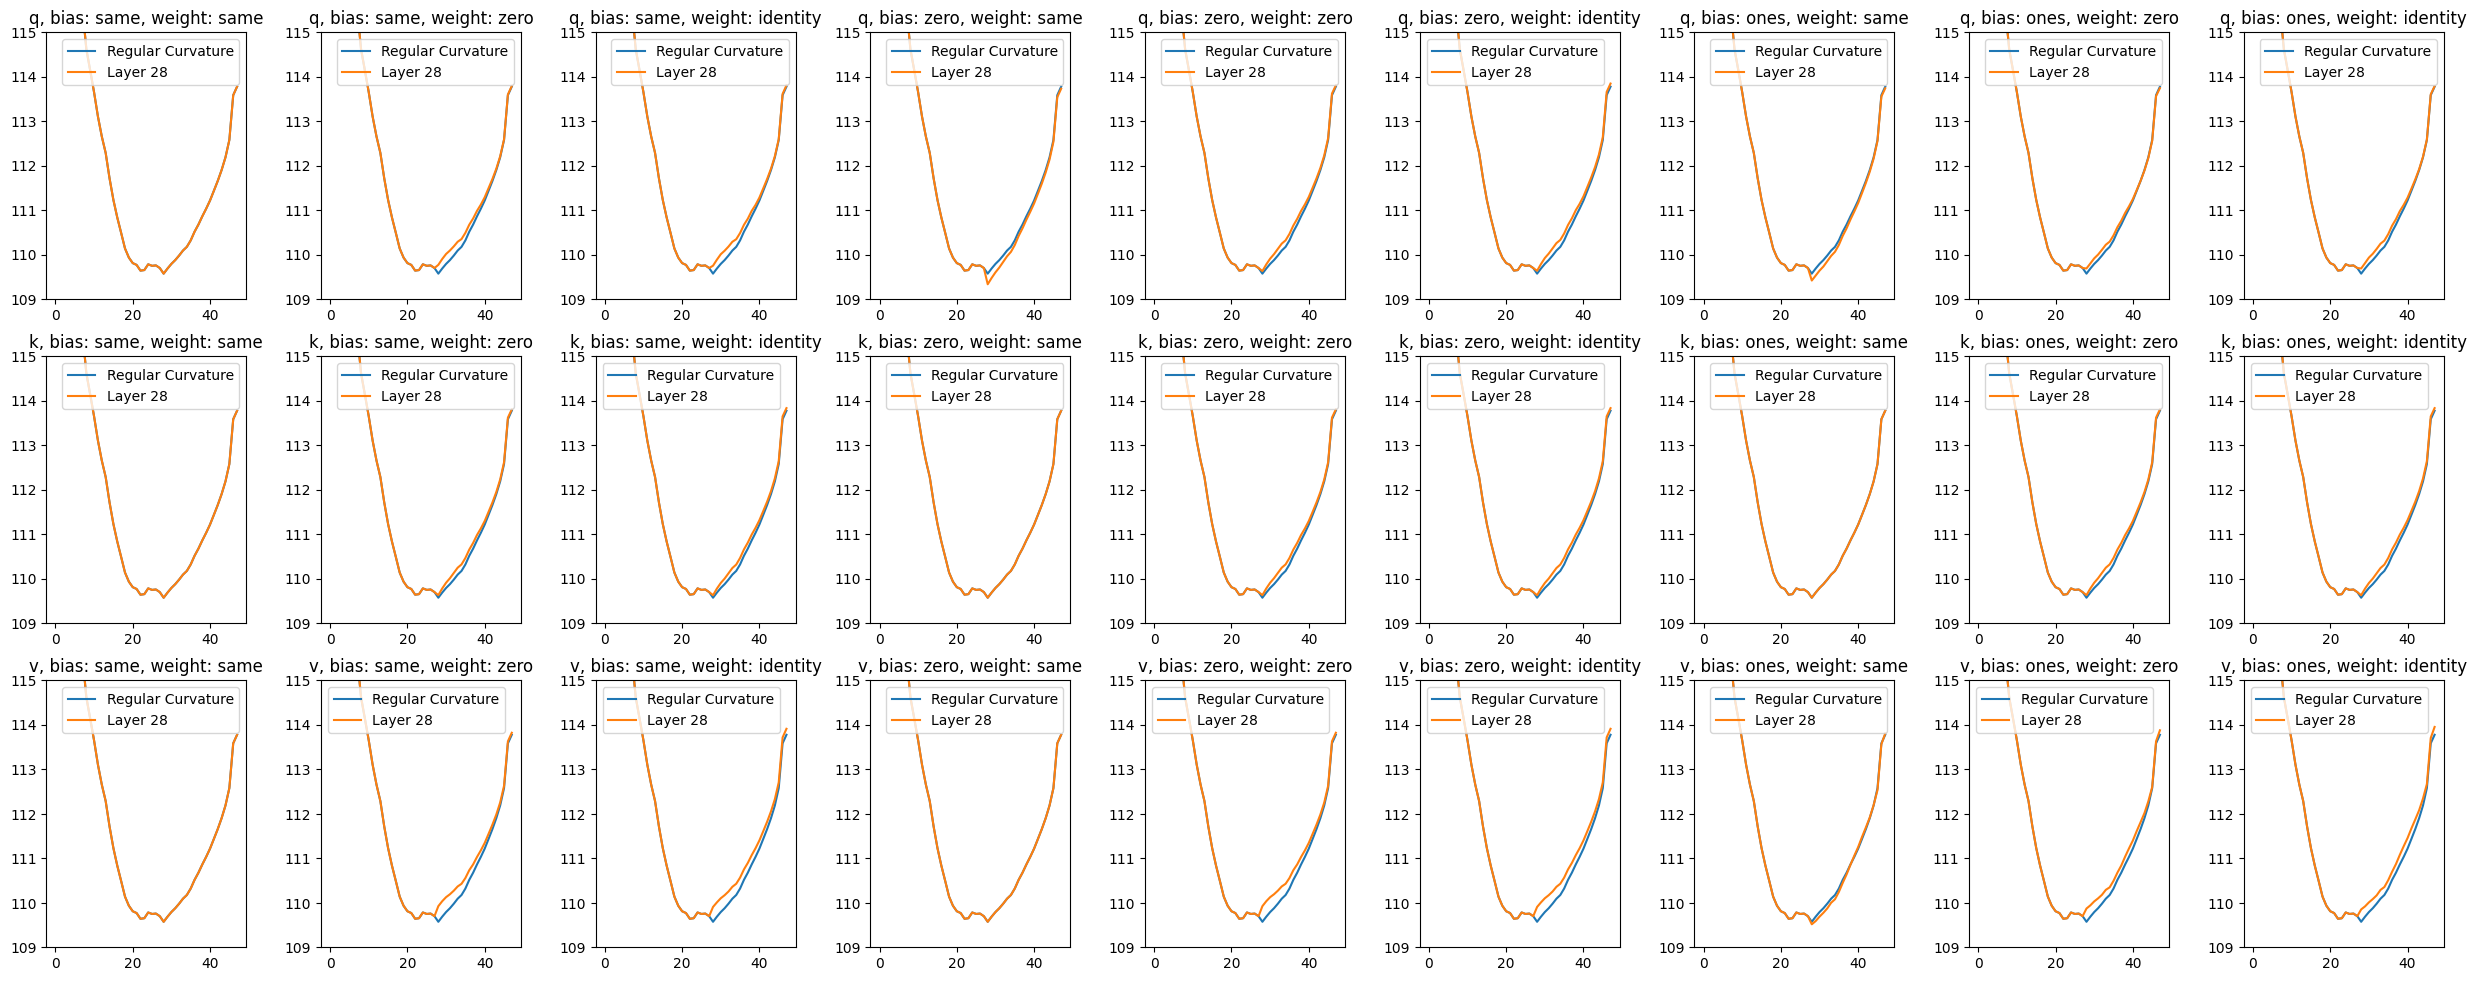

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `all_curvature_dicts` and `regular_curvature` are already defined

for layer in [14, 22, 28]:

    # Define the layout of the subplots
    fig, axes = plt.subplots(len(["Wq", "Wk", "Wv"]), len(["same", "zero", "ones"]) * len(["same", "zero", "identity"]), figsize=(25, 10))
    fig.tight_layout(pad=2.0)
    axes = axes.flatten()

    index = 0
    for location in ["q", "k", "v"]:
        for bias_type in ["same", "zero", "ones"]:
            for weight_type in ["same", "zero", "identity"]:
                ax = axes[index]
                index += 1
                
                curvatures = all_curvature_dicts[(location, weight_type, bias_type)][layer]
                ax.plot(regular_curvature["curve"].mean(axis=1) * 180 / np.pi, label='Regular Curvature')
                ax.plot(curvatures["curve"].mean(axis=1) * 180 / np.pi, label=f'Layer {layer}')
                
                ax.set_title(f"{location}, bias: {bias_type}, weight: {weight_type}")
                #set axis bounds
                ax.set_ylim([109, 115])
                ax.legend()

    # Show the complete figure with subplots
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


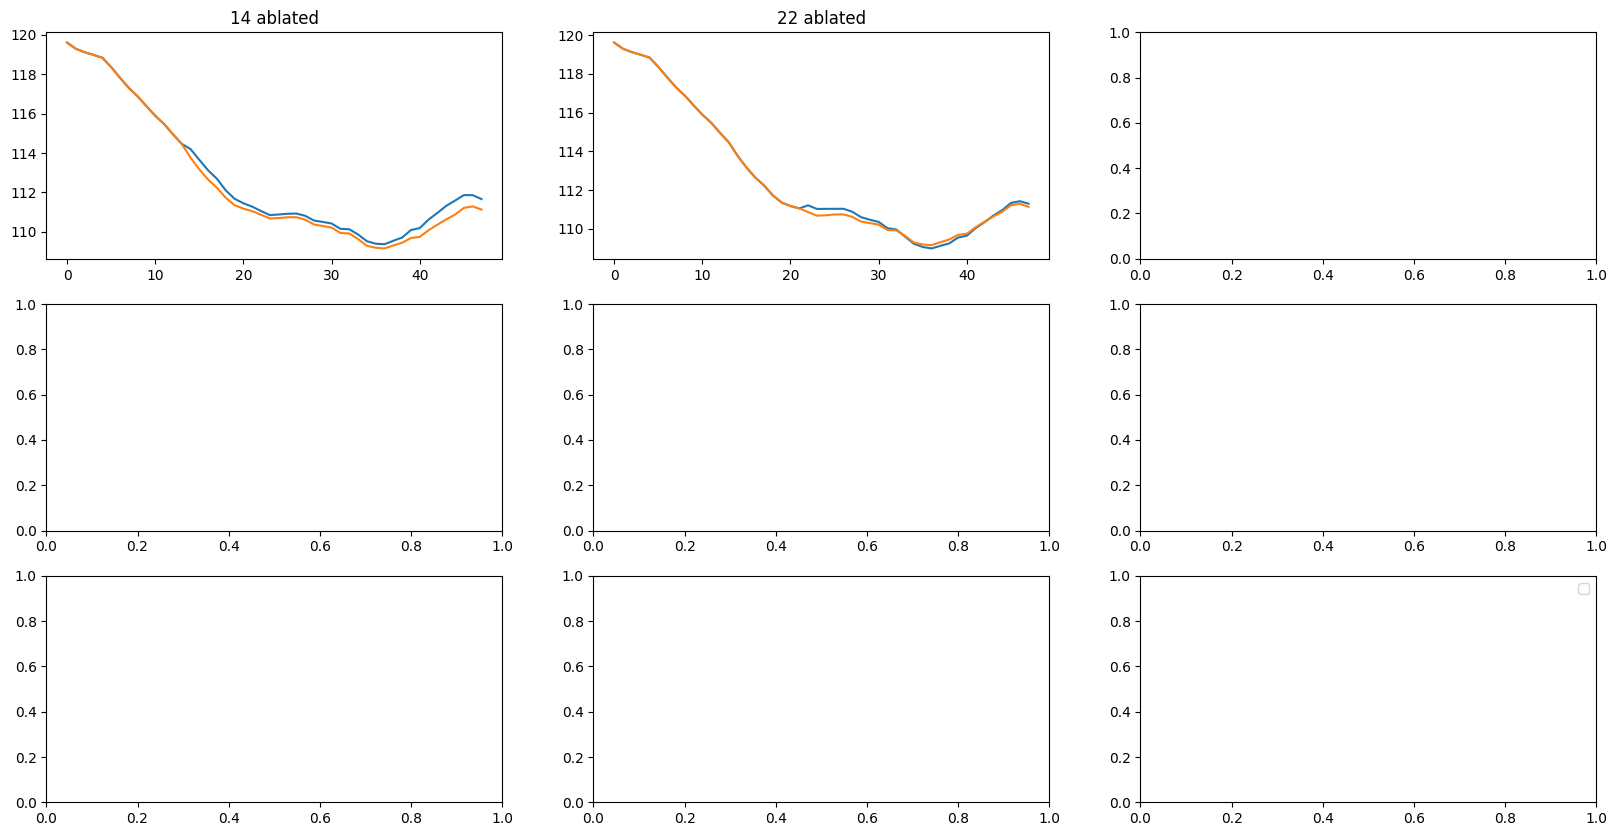

In [ ]:
#zeroed attention patterns
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for ax, (layer, curvatures) in zip(axs.flatten(), curvature_dict.items()):
    alac = np.array(curvatures["all_layer_curve_all"])
    alac = np.mean(alac, axis=0)[:, -1]
    ax.plot(alac * 180 / np.pi, label="Zeroed")
    alac_reg = np.array(regular_curvature["all_layer_curve_all"])
    alac_reg = np.mean(alac_reg, axis=0)[:, -1]
    ax.plot(alac_reg * 180 / np.pi, label="Regular")
    ax.set_title(f"{layer} ablated")
plt.legend()
plt.show()

In [ ]:
no_onescurvature_dict = {}
for layer in np.arange(10, 20):
    print(f"running {layer}")
    cache = get_cache(sentences, ("identity", "q"), model_name, model_config, bias_type=False, layer=layer)
    curvature = get_curvature_for_model(cache, sentences, model_config)
    no_onescurvature_dict[layer] = curvature

running 10
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.99it/s]


running 11
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.75it/s]


running 12
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.20it/s]


running 13
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.49it/s]


running 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.15it/s]


running 15
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.30it/s]


running 16
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.80it/s]


running 17
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.31it/s]


running 18
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.99it/s]


running 19
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.50it/s]


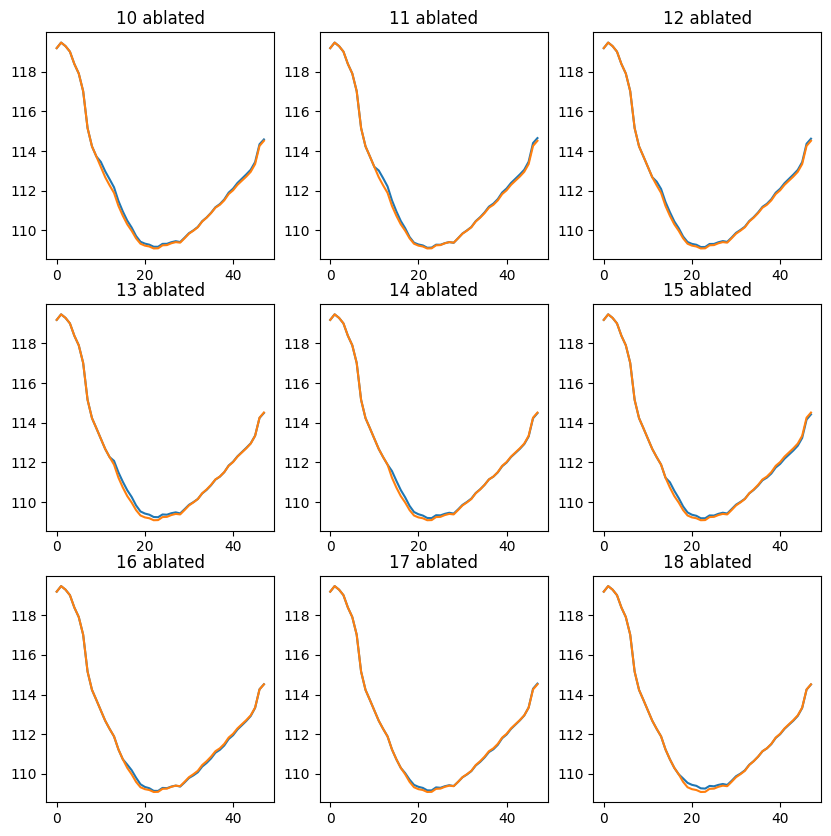

In [ ]:
# identity on q with no add ones
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for ax, (layer, curvatures) in zip(axs.flatten(), no_onescurvature_dict.items()):
    ax.plot(curvatures["curve"].mean(axis=1) * 180 / np.pi)
    ax.plot(no_ablate_curvature["curve"].mean(axis=1) * 180 / np.pi)
    ax.set_title(f"{layer} ablated")
plt.show()

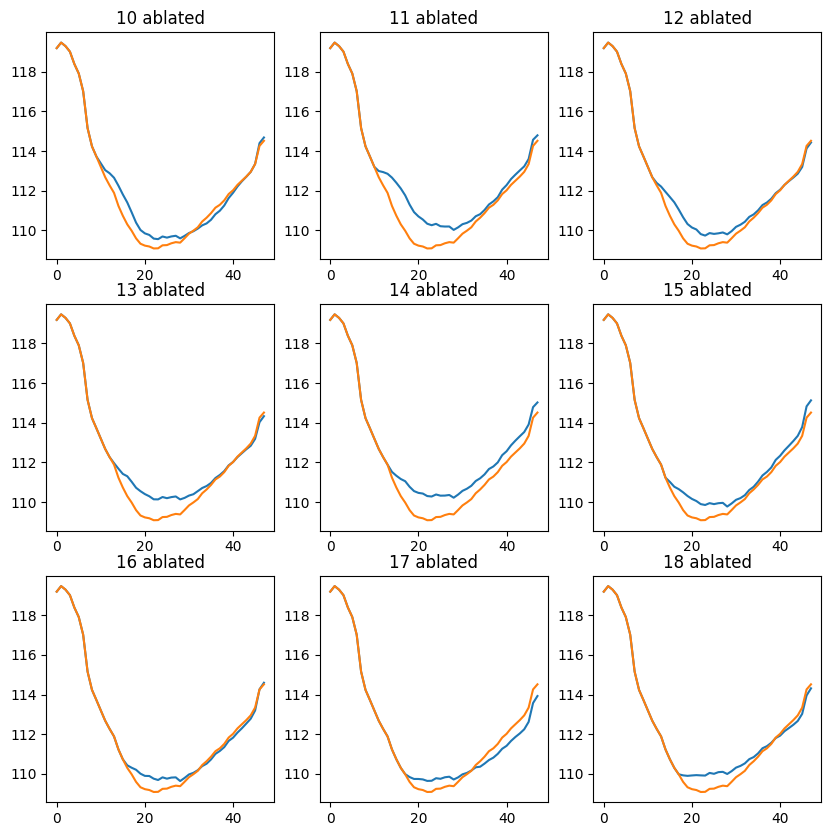

In [ ]:
# identity on q with add ones
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for ax, (layer, curvatures) in zip(axs.flatten(), no_onescurvature_dict.items()):
    ax.plot(curvatures["curve"].mean(axis=1) * 180 / np.pi)
    ax.plot(no_ablate_curvature["curve"].mean(axis=1) * 180 / np.pi)
    ax.set_title(f"{layer} ablated")
plt.show()

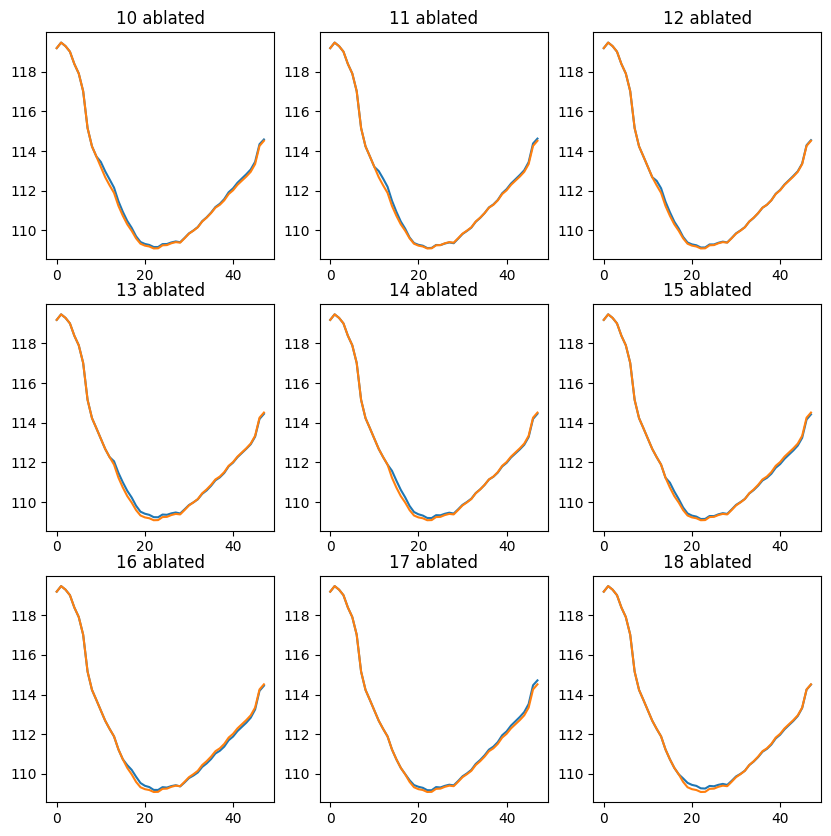

In [ ]:
# identity with no add ones
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for ax, (layer, curvatures) in zip(axs.flatten(), no_onescurvature_dict.items()):
    ax.plot(curvatures["curve"].mean(axis=1) * 180 / np.pi)
    ax.plot(no_ablate_curvature["curve"].mean(axis=1) * 180 / np.pi)
    ax.set_title(f"{layer} ablated")
plt.show()

In [ ]:
#randomly select 100 sentences from all_sentences
sentences = all_sentences[np.random.choice(all_sentences.shape[0], 100, replace=False)]
curvature_dict = {}
for layer in np.arange(10, 20):
    print(f"running {layer}")
    cache = get_cache(sentences, "identity", model_name, model_config, layer=layer)
    curvature = get_curvature_for_model(cache, sentences, model_config)
    curvature_dict[layer] = curvature

cache = get_cache(sentences, None, model_name, model_config)
no_ablate_curvature = get_curvature_for_model(cache, sentences, model_config)

running 10
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.70it/s]


running 11
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.17it/s]


running 12
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.83it/s]


running 13
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.62it/s]


running 14
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.51it/s]


running 15
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.26it/s]


running 16
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.17it/s]


running 17
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.40it/s]


running 18
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.12it/s]


running 19
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.40it/s]


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.61it/s]


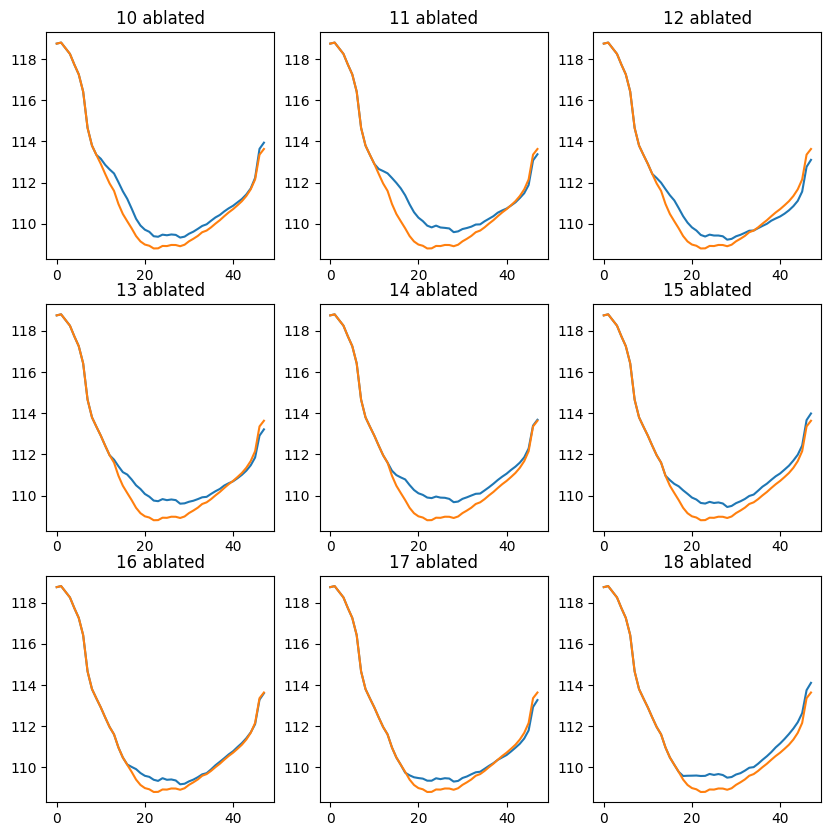

In [ ]:
# identity with add ones
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for ax, (layer, curvatures) in zip(axs.flatten(), curvature_dict.items()):
    ax.plot(curvatures["curve"].mean(axis=1) * 180 / np.pi)
    ax.plot(no_ablate_curvature["curve"].mean(axis=1) * 180 / np.pi)
    ax.set_title(f"{layer} ablated")
plt.show()

In [ ]:
orig_curvature_dict = {}
for layer in np.arange(10, 20):
    print(f"running {layer}")
    curvature = original_ablation_mechanism(sentences, layer)
    orig_curvature_dict[layer] = curvature

running 10
transformer.h.10.attn.c_attn.weight is ablated
transformer.h.10.attn.c_attn.bias is ablated
ablation on layer 10


  0%|          | 0/100 [00:00<?, ?it/s]/net/vast-storage/scratch/vast/evlab/jackking/modular_transformers/modular_transformers/straightening/straightening_utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens_tensor = torch.tensor(indexed_tokens[i]).to(device)
100%|██████████| 100/100 [00:02<00:00, 35.09it/s]
100it [00:01, 91.80it/s]


running 11
transformer.h.11.attn.c_attn.weight is ablated
transformer.h.11.attn.c_attn.bias is ablated
ablation on layer 11


100%|██████████| 100/100 [00:02<00:00, 34.92it/s]
100it [00:01, 91.13it/s]


running 12
transformer.h.12.attn.c_attn.weight is ablated
transformer.h.12.attn.c_attn.bias is ablated
ablation on layer 12


100%|██████████| 100/100 [00:02<00:00, 35.91it/s]
100it [00:01, 91.28it/s]


running 13
transformer.h.13.attn.c_attn.weight is ablated
transformer.h.13.attn.c_attn.bias is ablated
ablation on layer 13


100%|██████████| 100/100 [00:02<00:00, 35.09it/s]
100it [00:01, 91.43it/s]


running 14
transformer.h.14.attn.c_attn.weight is ablated
transformer.h.14.attn.c_attn.bias is ablated
ablation on layer 14


100%|██████████| 100/100 [00:02<00:00, 35.13it/s]
100it [00:01, 90.91it/s]


running 15
transformer.h.15.attn.c_attn.weight is ablated
transformer.h.15.attn.c_attn.bias is ablated
ablation on layer 15


100%|██████████| 100/100 [00:02<00:00, 34.82it/s]
100it [00:01, 90.59it/s]


running 16
transformer.h.16.attn.c_attn.weight is ablated
transformer.h.16.attn.c_attn.bias is ablated
ablation on layer 16


100%|██████████| 100/100 [00:02<00:00, 35.05it/s]
100it [00:01, 91.21it/s]


running 17
transformer.h.17.attn.c_attn.weight is ablated
transformer.h.17.attn.c_attn.bias is ablated
ablation on layer 17


100%|██████████| 100/100 [00:02<00:00, 34.71it/s]
100it [00:01, 91.18it/s]


running 18
transformer.h.18.attn.c_attn.weight is ablated
transformer.h.18.attn.c_attn.bias is ablated
ablation on layer 18


100%|██████████| 100/100 [00:02<00:00, 34.83it/s]
100it [00:01, 91.14it/s]


running 19
transformer.h.19.attn.c_attn.weight is ablated
transformer.h.19.attn.c_attn.bias is ablated
ablation on layer 19


100%|██████████| 100/100 [00:02<00:00, 35.37it/s]
100it [00:01, 91.01it/s]


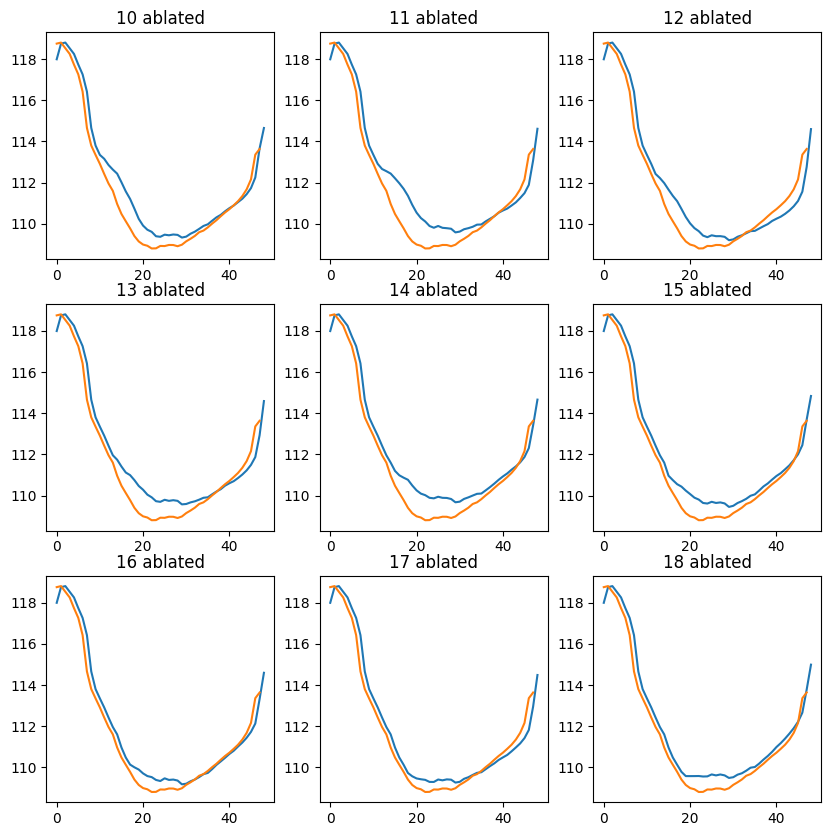

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for ax, (layer, curvatures) in zip(axs.flatten(), orig_curvature_dict.items()):
    ax.plot(curvatures["curve"].mean(axis=1) * 180 / np.pi)
    ax.plot(no_ablate_curvature["curve"].mean(axis=1) * 180 / np.pi)
    ax.set_title(f"{layer} ablated")
plt.show()

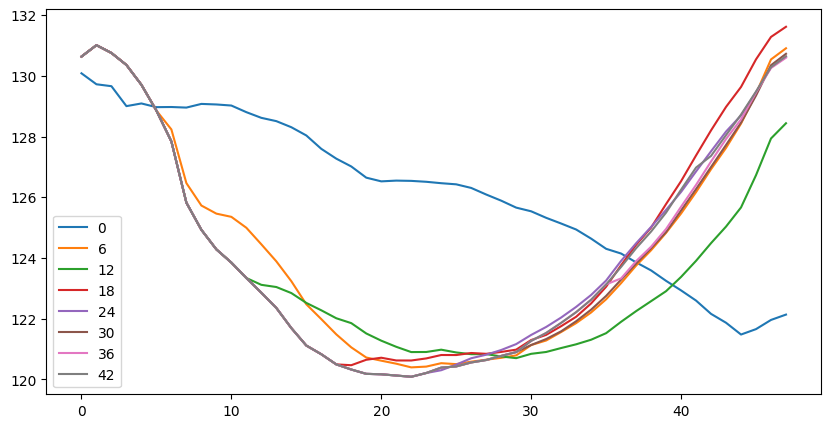

In [ ]:
plt.figure(figsize=(10, 5))
for layer, curvatures in curvature_dict.items():
    plt.plot(curvatures["curve"].mean(axis=1) * 180 / np.pi, label=layer)
#set fig size
plt.legend()
plt.show()

In [ ]:
sentences = all_sentences[:100]

In [ ]:
ablated_curvatures = get_curvature_for_model(sentences, "identity", model_name, model_config, 15)

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.61it/s]


In [ ]:
ablated_curvatures = get_curvature_for_model(sentences, "identity", model_name, model_config, 15)
old_ablated_curvatures = get_jawn(sentences)
non_ablated_curvatures = get_curvature_for_model(sentences, None, model_name, model_config)

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.51it/s]


transformer.h.15.attn.c_attn.weight is ablated
transformer.h.15.attn.c_attn.bias is ablated
ablation on layer 15


  0%|          | 0/100 [00:00<?, ?it/s]/net/vast-storage/scratch/vast/evlab/jackking/modular_transformers/modular_transformers/straightening/straightening_utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens_tensor = torch.tensor(indexed_tokens[i]).to(device)
100%|██████████| 100/100 [00:02<00:00, 34.24it/s]
100it [00:01, 90.27it/s]


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 92.93it/s]


In [ ]:
sentences = all_sentences[:100]
normal_curvatures = get_curvature_for_ablated_model(sentences, None, model_name, model_config)
curvature_dict = {}
for layer in [5, 15, 30, 45]:
    ablated_curvatures = get_curvature_for_ablated_model(sentences, "identity", model_name, model_config, layer)
    curvature_dict[layer] = ablated_curvatures

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 94.00it/s]


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.17it/s]


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.60it/s]


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.75it/s]


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


100it [00:01, 93.78it/s]


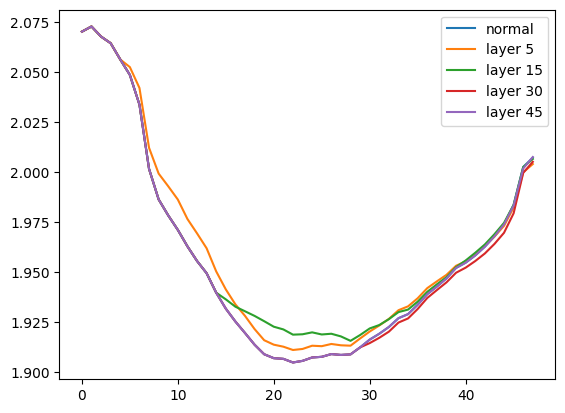

In [ ]:
plt.plot(np.mean(normal_curvatures["curve"], axis=1), label="normal")
for layer in curvature_dict.keys():
    plt.plot(np.mean(curvature_dict[layer]["curve"], axis=1), label=f"layer {layer}")

plt.legend()
plt.show()

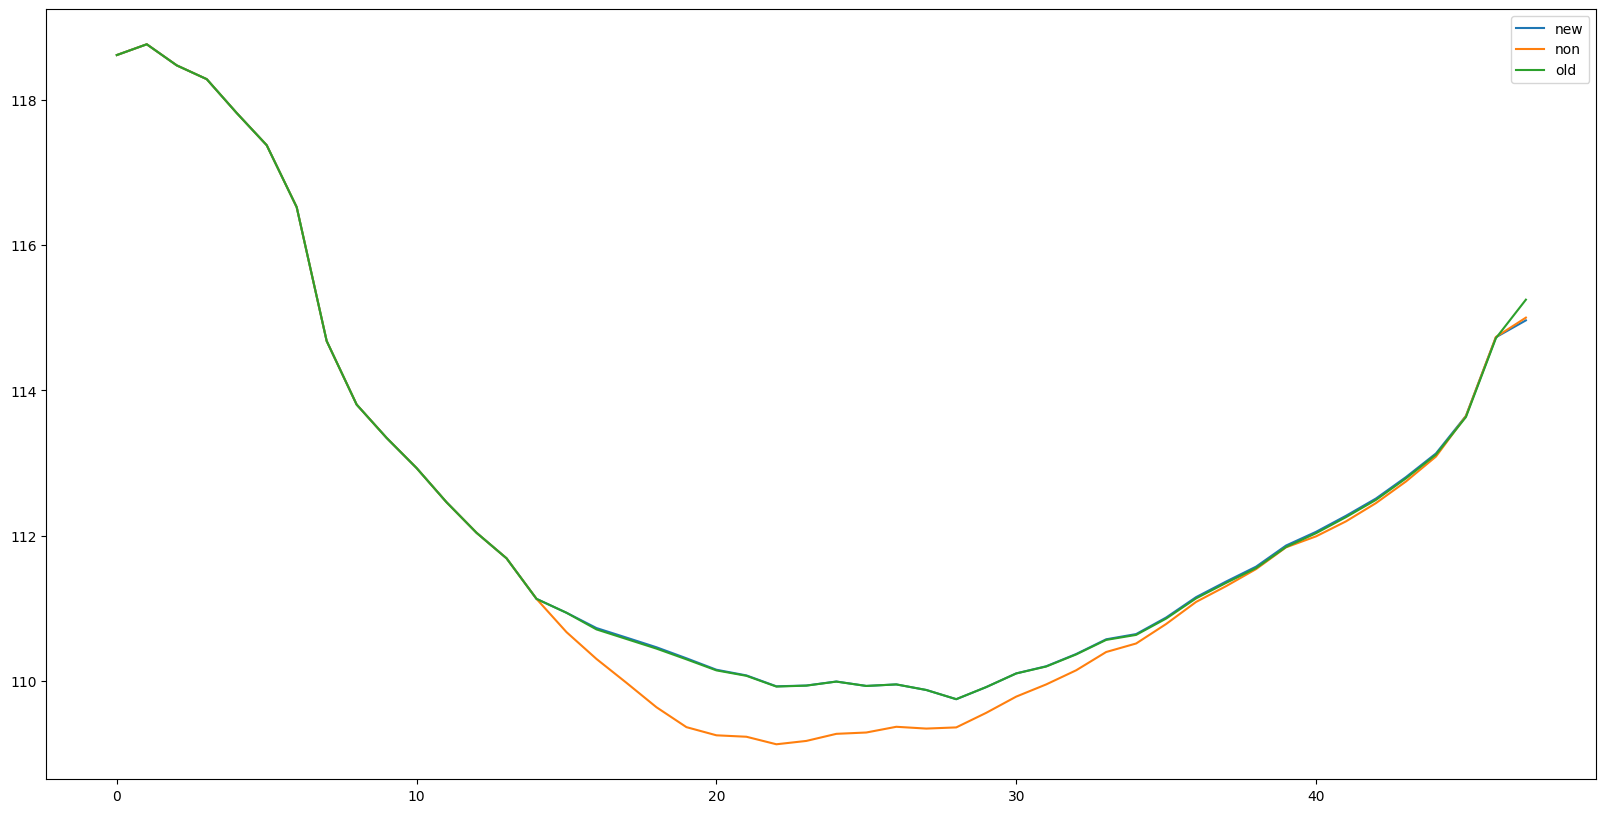

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.mean(ablated_curvatures["curve"][:], axis=1) * 180 / np.pi, label="new")
plt.plot(np.mean(non_ablated_curvatures["curve"][:], axis=1) * 180 / np.pi, label="non")
plt.plot(np.mean(old_ablated_curvatures["curve"][1:], axis=1) * 180 / np.pi, label="old")
plt.legend()
plt.show()

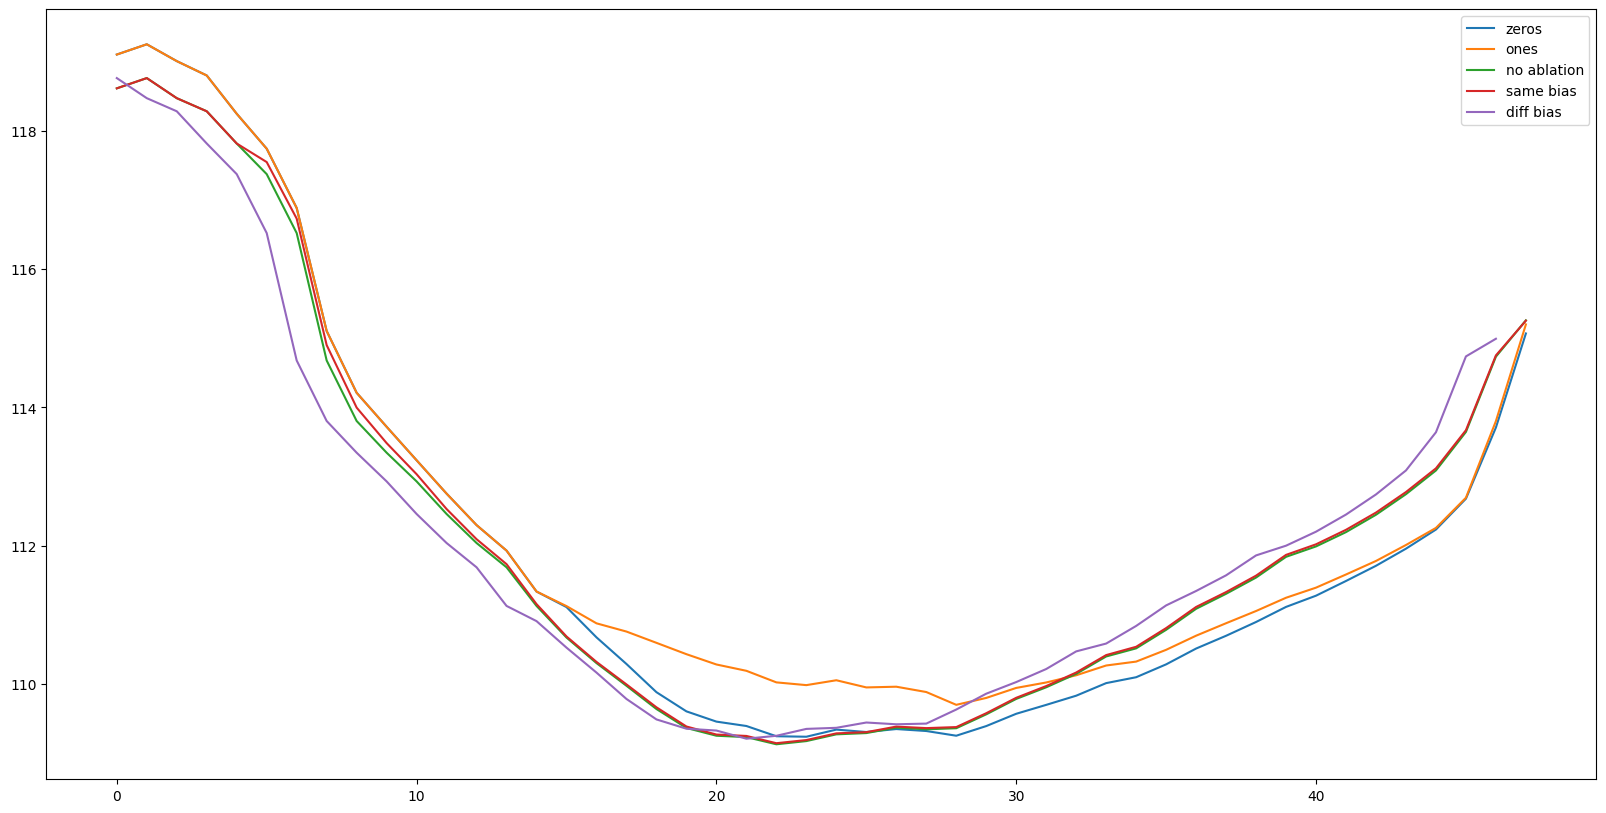

In [ ]:
plt.figure(figsize=(20, 10))
# plt.plot(np.mean(normal_curvatures["curve"], axis=1) * 180 / np.pi, label="normal")
# plt.plot(np.mean(ablated_curvatures["curve"], axis=1) * 180 / np.pi, label="ablated")
plt.plot(np.mean(curvatures["curve"][1:], axis=1) * 180 / np.pi, label="zeros")
plt.plot(np.mean(other_curvatures["curve"][1:], axis=1) * 180 / np.pi, label="ones")
plt.plot(np.mean(orig_curvatures["curve"][1:], axis=1) * 180 / np.pi, label="no ablation")
plt.plot(np.mean(bias_same["curve"][1:], axis=1) * 180 / np.pi, label="same bias")
plt.plot(np.mean(ablated_curvatures["curve"][1:], axis=1) * 180 / np.pi, label="diff bias")
plt.legend()
plt.show()

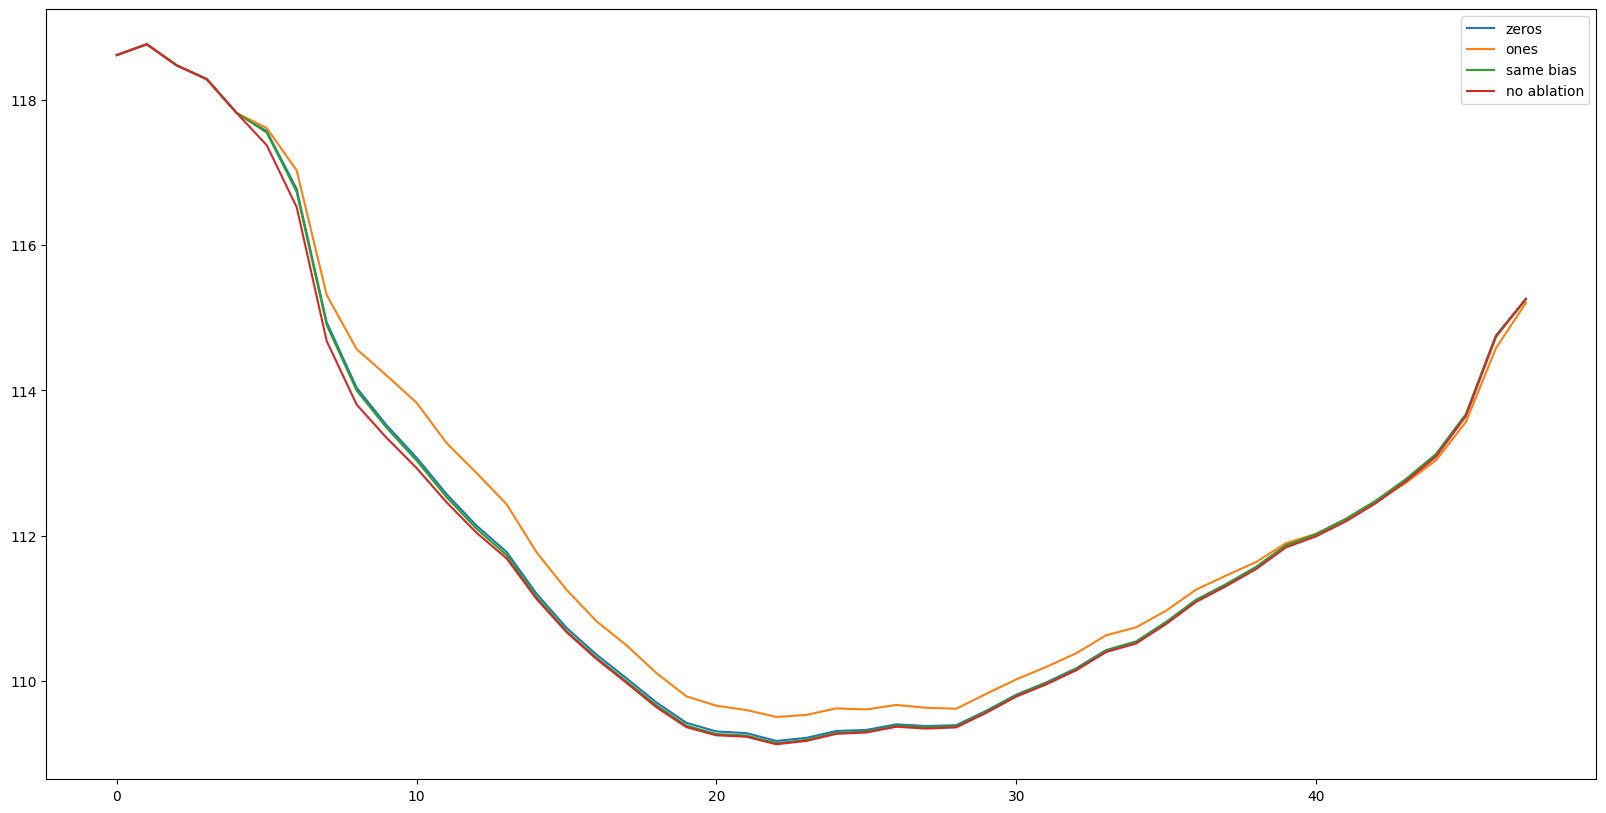

In [ ]:
plt.figure(figsize=(20, 10))
# plt.plot(np.mean(normal_curvatures["curve"], axis=1) * 180 / np.pi, label="normal")
# plt.plot(np.mean(ablated_curvatures["curve"], axis=1) * 180 / np.pi, label="ablated")
plt.plot(np.mean(fivee_zeros["curve"][1:], axis=1) * 180 / np.pi, label="zeros")
plt.plot(np.mean(five_ones["curve"][1:], axis=1) * 180 / np.pi, label="ones")
plt.plot(np.mean(bias_same["curve"][1:], axis=1) * 180 / np.pi, label="same bias")
plt.plot(np.mean(orig_curvatures["curve"][1:], axis=1) * 180 / np.pi, label="no ablation")
plt.legend()
plt.show()

## Testing Impact of Context on Final Surprisal

In [7]:
datasource = "ud"
sentence_length = 10
datatype = f"{datasource}/{sentence_length}_word"
model_name = "gpt2-xl"
model_config = AutoConfig.from_pretrained(model_name)
num_sent_selected = 200

sentences, curvatures = get_random_sentences(datatype, model_name, num_sent_selected)

In [8]:
def get_surprisals(logits):
    log_probs = -F.log_softmax(logits, dim=-1)
    surprisals = []
    for i in range(len(sentences)):
        #find the surprisal of each place in the context predicting the next token
        last_token_index = sentences[i, -1]
        token_log_probs = log_probs[i, -2, last_token_index] #the surprisal of the second to last token predicting the last token
        surprisals.append(token_log_probs.cpu().numpy())
    return surprisals

In [23]:
def partial_ablation(tokens, weight_type):
    all_surprisals = []

    for layer in range(47, 48):
        torch.cuda.empty_cache()
        layers = np.arange(layer-47, layer)
        print(layers)
        ablated_logits, ablated_cache = get_cache(sentences, model_name, model_config, weight_type = "zero", ablation_location=None, layers=layers, tokens=tokens, return_logits=True)
        # ablated_logits, ablated_cache = get_cache(sentences, model_name, model_config, weight_type = weight_type, ablation_location="pattern", layers=layers, tokens=tokens, return_logits=True)
        surprisals = get_surprisals(ablated_logits)
        all_surprisals.append(surprisals)

    all_surprisals = np.array(all_surprisals)
    return all_surprisals

In [47]:
from scipy.stats import entropy

def calculate_kl(x, y, axis):
    tensor1 = x / x.sum(axis=axis, keepdims=True)
    tensor2 = y / y.sum(axis=axis, keepdims=True)
    #remove zeros
    tensor1 = np.clip(tensor1, 1e-12, 1)
    tensor2 = np.clip(tensor2, 1e-12, 1)
    kl_divergence = np.sum(tensor1 * (np.log(tensor1) - np.log(tensor2)), axis=axis)
    return entropy(x, y)
    # return kl_divergence

In [95]:
def partial_ablation_with_KL_dv(tokens, weight_type, original_distribution):
    all_KL_divergences = []

    for layer in range(47, 48):
        torch.cuda.empty_cache()
        layers = np.arange(layer-47, layer)
        layers = [0]
        # ablated_logits, ablated_cache = get_cache(sentences, model_name, model_config, weight_type = weight_type, ablation_location="pattern", layers=layers, tokens=tokens, return_logits=True)
        ablated_logits, ablated_cache = get_cache(sentences, model_name, model_config, weight_type = "zero", ablation_location=None, layers=layers, tokens=tokens, return_logits=True)
        output_distributions = F.softmax(ablated_logits, dim=-1).cpu().numpy()[:, -1, :]
        KL_divergences = []
        for i in range(len(sentences)):
            KL_divergences.append(calculate_kl(output_distributions[i], original_distribution[i], axis=0))
            print(tokenizer.decode(sentences[i]))
            index = torch.argmax(ablated_logits[i, -1])
            print(tokenizer.decode(index))
        all_KL_divergences.append(KL_divergences)
        #outputted word
        print(tokenizer.decode(sentences[0]))
        index = torch.argmax(ablated_logits[0, -1])
        print(tokenizer.decode(index))


    all_KL_divergences = np.array(all_KL_divergences)
    return all_KL_divergences

In [96]:
# regular_logits, regular_cache = get_cache(sentences, model_name, model_config, return_logits=True)
# original_distribution = F.softmax(regular_logits, dim=-1).cpu().numpy()[:, -1, :]
# print(tokenizer.decode(sentences[0]))
# index = torch.argmax(regular_logits[0, -1])
# print(tokenizer.decode(index))

offset = 5

# first_half_tokens = np.arange(0, sentence_length-offset)
# first_half_ablated_divergences = partial_ablation_with_KL_dv(first_half_tokens, "zero", original_distribution)

# second_half_tokens = np.arange(offset, sentence_length)
# second_half_ablated_divergences = partial_ablation_with_KL_dv(second_half_tokens, "zero", original_distribution)

all_tokens = np.arange(0, sentence_length)
all_ablated_divergences = partial_ablation_with_KL_dv(all_tokens, "zero", original_distribution)

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
I have heard that the pipefitters have established
The
The lesion is further evidence of Al Qaeda's
The
General Gordon left behind him a uniquely detailed diary of
The
this is not where the Blue Water Bridge Duty Free
The
I put my foot in the water and it was
The
Then he started to see the real horrors of war
The
They let Harry out to use the bathroom morning and
The
It's an adorable little store filled with lots of
The
There would be a charge of thirty cents, he
The
But not at a risk to other people's pets
The
It seemed as though things had ground to a halt
The
Maybe I should just let that process unfold, maybe
The
His wife was listening, laughing softly, sitting back
The
Lo and behold, the Mormons were there with a
The
The city residences became expressions of the riches and power
The
Once a car nearly ran him over as he was
The
The rock dropped to the ground, blood-sl
The
I have also purchased an Ap

In [97]:
all_ablated_divergences.mean()

9.757796

In [56]:
all_ablated_divergences.mean()

0.00054358534

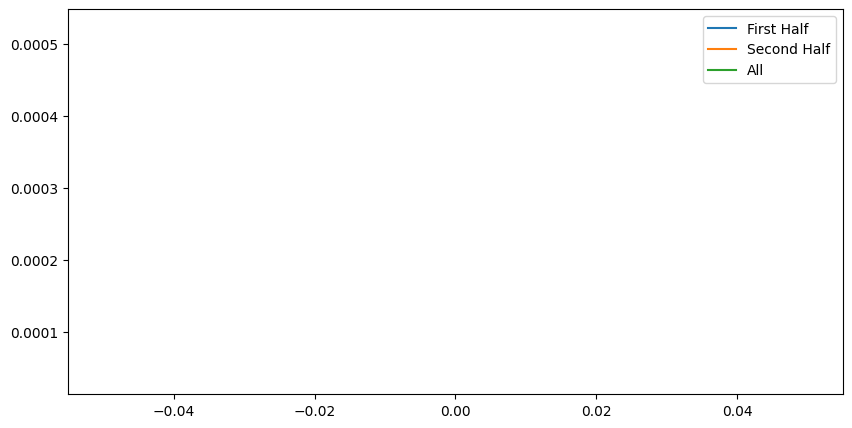

In [51]:
plt.figure(figsize=(10,5))
plt.plot(np.mean(first_half_ablated_divergences, axis=1), label="First Half")
plt.plot(np.mean(second_half_ablated_divergences, axis=1), label="Second Half")
plt.plot(np.mean(all_ablated_divergences, axis=1), label="All")
plt.legend()
plt.show()

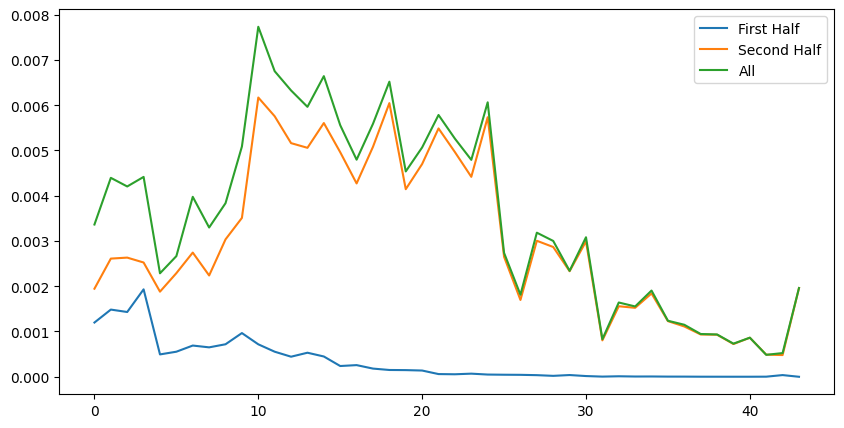

In [13]:
plt.figure(figsize=(10,5))
plt.plot(np.mean(first_half_ablated_divergences, axis=1), label="First Half")
plt.plot(np.mean(second_half_ablated_divergences, axis=1), label="Second Half")
plt.plot(np.mean(all_ablated_divergences, axis=1), label="All")
plt.legend()
plt.show()

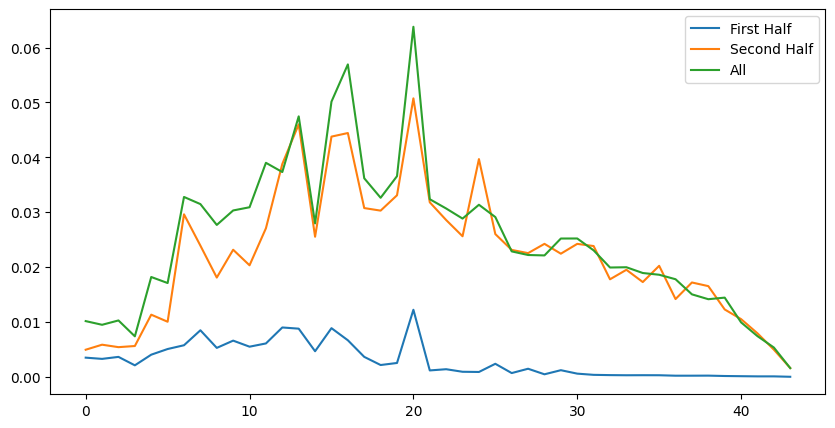

In [22]:
plt.figure(figsize=(10,5))
plt.plot(np.mean(first_half_ablated_divergences, axis=1), label="First Half")
plt.plot(np.mean(second_half_ablated_divergences, axis=1), label="Second Half")
plt.plot(np.mean(all_ablated_divergences, axis=1), label="All")
plt.legend()
plt.show()

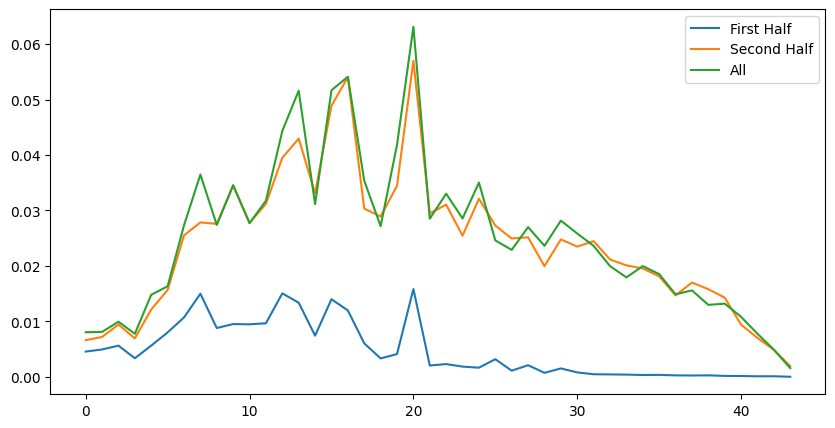

In [20]:
plt.figure(figsize=(10,5))
plt.plot(np.mean(first_half_ablated_divergences, axis=1), label="First Half")
plt.plot(np.mean(second_half_ablated_divergences, axis=1), label="Second Half")
plt.plot(np.mean(all_ablated_divergences, axis=1), label="All")
plt.legend()
plt.show()

In [17]:
offset = 5

# first_half_tokens = np.arange(0, sentence_length-offset)
# first_half_ablated_surprisals = partial_ablation(first_half_tokens, "noise")

# second_half_tokens = np.arange(sentence_length-offset, sentence_length)
# second_half_ablated_surprisals = partial_ablation(second_half_tokens, "noise")

all_tokens = np.arange(0, sentence_length)
all_ablated_surprisals = partial_ablation(all_tokens, "zero")

regular_logits, regular_cache = get_cache(sentences, model_name, model_config, return_logits=True)
regular_surprisals = get_surprisals(regular_logits)

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


In [18]:
(all_ablated_surprisals - regular_surprisals).mean()

-0.0037606084

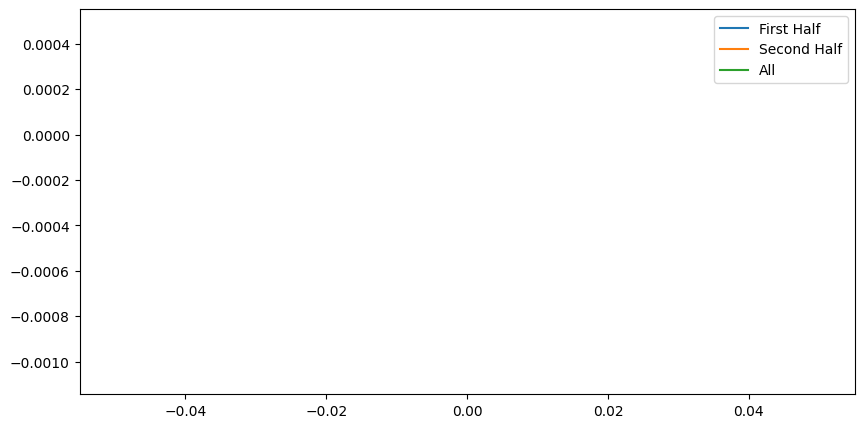

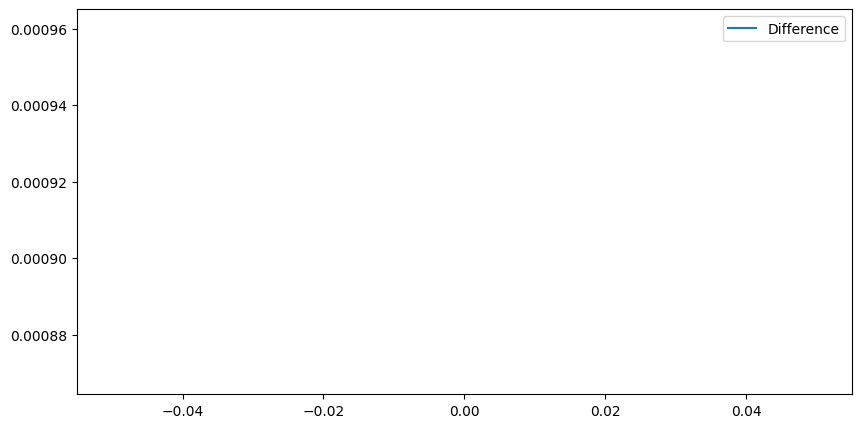

In [35]:
plt.figure(figsize=(10,5))
plt.plot(np.mean(first_half_ablated_surprisals - regular_surprisals, axis=1), label="First Half")
std = np.std(first_half_ablated_surprisals - regular_surprisals, axis=1) / np.sqrt(200)
plt.fill_between(np.arange(first_half_ablated_surprisals.shape[0]), np.mean(first_half_ablated_surprisals - regular_surprisals, axis=1) - std, np.mean(first_half_ablated_surprisals - regular_surprisals, axis=1) + std, alpha=0.5)
plt.plot(np.mean(second_half_ablated_surprisals - regular_surprisals, axis=1), label="Second Half")
plt.plot(np.mean(all_ablated_surprisals - regular_surprisals, axis=1), label="All")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.mean(first_half_ablated_surprisals - second_half_ablated_surprisals, axis=1), label="Difference")
plt.legend()
plt.show()

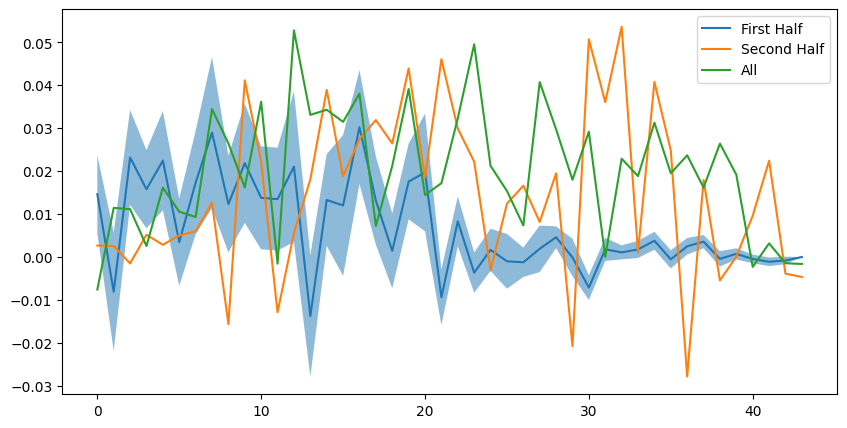

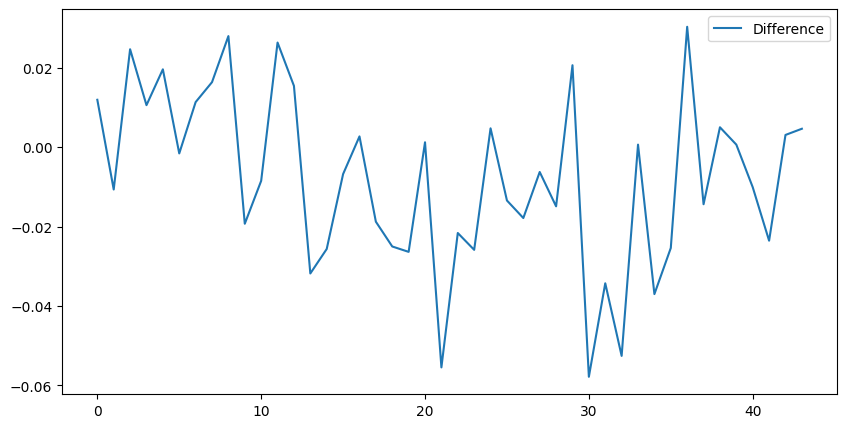

In [24]:
plt.figure(figsize=(10,5))
plt.plot(np.mean(first_half_ablated_surprisals - regular_surprisals, axis=1), label="First Half")
std = np.std(first_half_ablated_surprisals - regular_surprisals, axis=1) / np.sqrt(200)
plt.fill_between(np.arange(first_half_ablated_surprisals.shape[0]), np.mean(first_half_ablated_surprisals - regular_surprisals, axis=1) - std, np.mean(first_half_ablated_surprisals - regular_surprisals, axis=1) + std, alpha=0.5)
plt.plot(np.mean(second_half_ablated_surprisals - regular_surprisals, axis=1), label="Second Half")
plt.plot(np.mean(all_ablated_surprisals - regular_surprisals, axis=1), label="All")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.mean(first_half_ablated_surprisals - second_half_ablated_surprisals, axis=1), label="Difference")
plt.legend()
plt.show()

In [25]:
offset = 3

first_half_tokens = np.arange(0, sentence_length-offset)
first_half_ablated_surprisals = partial_ablation(first_half_tokens, "zero")

second_half_tokens = np.arange(sentence_length-offset, sentence_length)
second_half_ablated_surprisals = partial_ablation(second_half_tokens, "zero")
 
all_tokens = np.arange(0, sentence_length)
all_ablated_surprisals = partial_ablation(all_tokens, "zero")

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model gpt2-xl into HookedTransformer
Moving mod

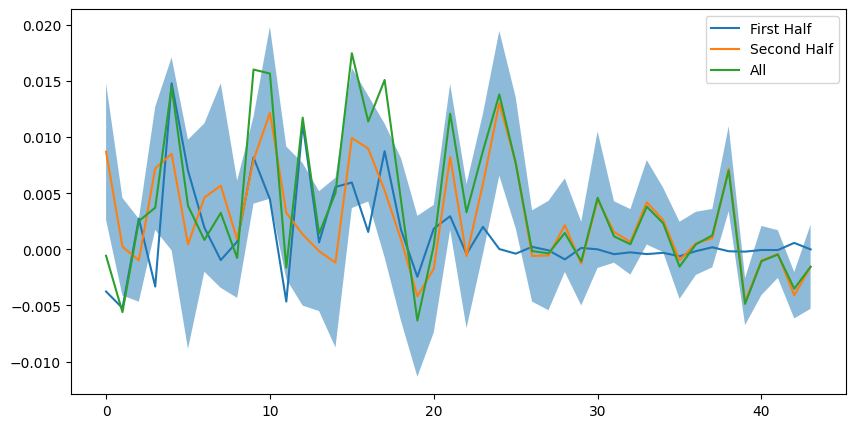

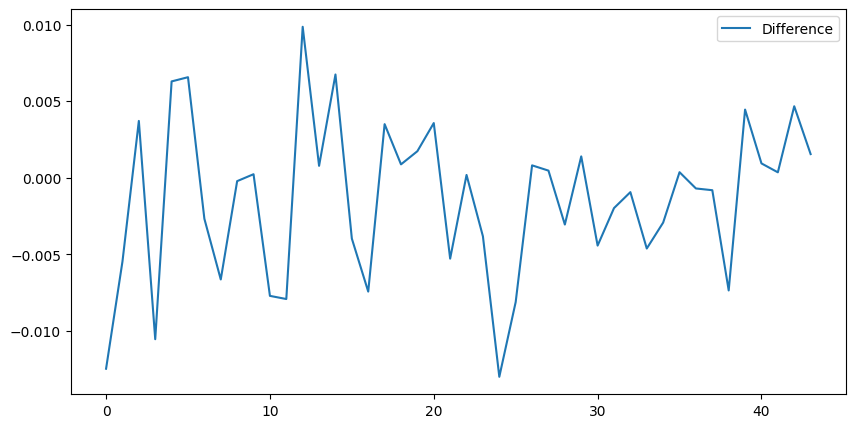

In [26]:
plt.figure(figsize=(10,5))
plt.plot(np.mean(first_half_ablated_surprisals - regular_surprisals, axis=1), label="First Half")
std = np.std(second_half_ablated_surprisals - regular_surprisals, axis=1) / np.sqrt(200)
plt.fill_between(np.arange(second_half_ablated_surprisals.shape[0]), np.mean(second_half_ablated_surprisals - regular_surprisals, axis=1) - std, np.mean(second_half_ablated_surprisals - regular_surprisals, axis=1) + std, alpha=0.5)
plt.plot(np.mean(second_half_ablated_surprisals - regular_surprisals, axis=1), label="Second Half")
plt.plot(np.mean(all_ablated_surprisals - regular_surprisals, axis=1), label="All")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.mean(first_half_ablated_surprisals - second_half_ablated_surprisals, axis=1), label="Difference")
plt.legend()
plt.show()

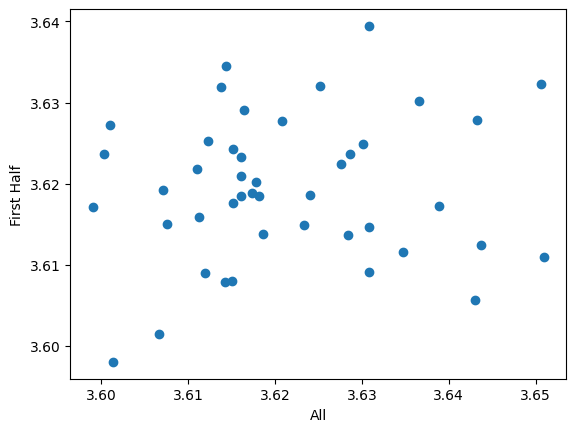

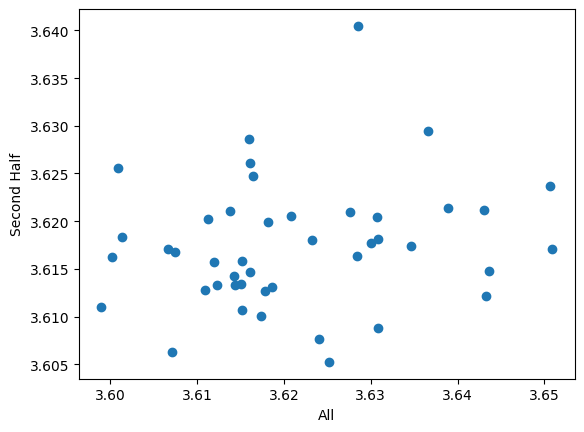

In [62]:
plt.scatter(np.mean(all_ablated_surprisals, axis=1), np.mean(first_half_ablated_surprisals, axis=1))
# plt.plot(np.arange(3.650, 3.680, 0.01), np.arange(3.650, 3.680, 0.01))
plt.xlabel("All")
plt.ylabel("First Half")
plt.show()
plt.scatter(np.mean(all_ablated_surprisals, axis=1), np.mean(second_half_ablated_surprisals, axis=1))
# plt.plot(np.arange(3.650, 3.680, 0.01), np.arange(3.650, 3.680, 0.01))
plt.xlabel("All")
plt.ylabel("Second Half")
plt.show()